## Boundary Layer Model - V02

Kepert 2001

CONCLUSIONS: K et C jouent un rôle similaire sur l'asymétrie et l'intensité du TC. 

Ut semble ajouter une instabilité de nombre d'onde +-1 d'autant plus forte que Ut est grand. Si C est fort, cela va amplifier l'asymétrie. 

On en conclut que les zones de fortes asymétries ont un C élevé (Ut étant égal par ailleurs). On va donc pouvoir mettre un lambda élevé dans Kalashnik aux endroits où l'asymétrie est forte.

*** Main problems:

- L'inflow angle décroît après 2*Rmax, comme dans SM2020.

- Neglects vertical advection of angular momentum (may explain above point, check with Foster).

NB: Kepert's model gives storm-relative flow.

Peut-être à recouper avec le Shapiro

TODO: isoler 2 cas SAR avec la même vitesse de translation mais des asymétries différentes et en faire des conclusions sur leur Cd respectifs.

*** MAIN CONCLUSIONS: 

- B parameter impacts med/large-scale asymmetries; Can we use the asymmetry from scatterometer data to find information on B?

- C parameter impacts near-core asymmetries; Can we use this information to find information on C (and thus on lambda in Kalashnik)?

- Almost no difference between the I > V/r solution and the I < V/r solution, so we can't use that to deduce something on L (characteristic scale of Kalashnik).

In [1]:
# General
import glob
import re
import os.path
# import warnings
# warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
import copy

# Arrays & Displays
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import pandas as pd

# Data treatment
from datetime import datetime
from scipy.optimize import curve_fit

# Custom
import functions as f
import dataUtils as du

# Statistics
from sklearn import linear_model, neighbors
from pykalman import KalmanFilter

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
####-----------####
#### FUNCTIONS ####
####-----------####

### MODEL
def coriolis(lat):
    '''Absolute vorticity.
    Latitude must be in degrees.'''
    Omega = 7.2921e-5                            # Earth rotation vector
    fcor  = 2 * Omega * np.sin(lat * np.pi / 180) # Coriolis parameter at 20° latitude and assuming it's constant 
    return fcor

def vorticity(r, v):
    '''Relative vorticity'''
    dr = 1000 # meters
    return (1 / r) * np.gradient(r * v, dr)

def h80(r, vm, rm, B, lat, vmin=0):
    '''Holland 1980 profile.'''
    fcor = coriolis(lat)
    V    = r * 0.
    V    = vmin + np.sqrt((vm ** 2) * ((rm / r) ** B) * np.exp(1 - (rm / r) ** B) + (r * fcor / 2) ** 2) - (r * fcor / 2)
    return V

In [3]:
rs = np.linspace(10, 8e5, 800)
vmx = 50
rmx = 50000
B   = 2
lat = 20
K   = 50 # m2/s
Cd  = 2e-3
Ut  = 5     # Translation speed
C   = 2.5e-3 

V   = h80(rs, vmx, rmx, B, lat)
fcor= coriolis(lat)

# plt.plot(rs, v);plt.grid()

In [4]:
# Inertial stability
def I(r, v, fcor):
    dr   = np.unique(np.diff(r))[0] # meters
    ksi  = 2 * v / r + fcor
    zeta = np.gradient(v, dr) + v / r + fcor
    return np.sqrt(ksi * zeta)

# Coefficients
def sqrt_alpha_beta(r, V, fcor):
    '''Corresponds to sqrt(alpha / beta).'''
    dr   = np.unique(np.diff(r))[0] # meters
    ksi  = 2 * V / r + fcor
    zeta = np.gradient(V, dr) + V / r + fcor
    return np.sqrt(ksi / zeta)

def eta(r, V, K, C, fcor):
    return C * V * np.sqrt(2 / (K * ((V / r) + I(r, V, fcor))))

def ki(r, V, K, C, fcor):
    return C * V * np.sqrt(2 / (K * I(r, V, fcor)))

def psi(r, V, K, C, fcor):
    return C * V * np.sqrt(2 / abs(K * ((V / r) - I(r, V, fcor))))

# Amplitudes
def A0(r, V, K, C, fcor):
    num = -ki(r, V, K, C, fcor) * V * [1 + 1j * (1 + ki(r, V, K, C, fcor))]
    den = 2 * ki(r, V, K, C, fcor) ** 2 + 3 * ki(r, V, K, C, fcor) + 2
    return num / den

def A1(r, V, Ut, K, C, fcor):
    num = -eta(r, V, K, C, fcor) * Ut * [1 - 2 * sqrt_alpha_beta(r, V, fcor) + (1 + 1j) * (1 - sqrt_alpha_beta(r, V, fcor)) * psi(r, V, K, C, fcor)]
    den = sqrt_alpha_beta(r, V, fcor) * [(2 + 2j) * (1 + eta(r, V, K, C, fcor) * psi(r, V, K, C, fcor)) + 3 * eta(r, V, K, C, fcor) + 3j * psi(r, V, K, C, fcor)]
    return num / den

def A_1(r, V, Ut, K, C, fcor):
    num = -psi(r, V, K, C, fcor) * Ut * [1 + 2 * sqrt_alpha_beta(r, V, fcor) + (1 + 1j) * (1 + sqrt_alpha_beta(r, V, fcor)) * eta(r, V, K, C, fcor)]
    den = sqrt_alpha_beta(r, V, fcor) * [(2 + 2j) * (1 + eta(r, V, K, C, fcor) * psi(r, V, K, C, fcor)) + 3 * psi(r, V, K, C, fcor) + 3j * eta(r, V, K, C, fcor)]
    return num / den

def A1_prime(r, V, Ut, K, C, fcor):
    num = -eta(r, V, K, C, fcor) * Ut * [1 - 2 * sqrt_alpha_beta(r, V, fcor) + (1 - 1j) * (1 - sqrt_alpha_beta(r, V, fcor)) * psi(r, V, K, C, fcor)]
    den = sqrt_alpha_beta(r, V, fcor) * [2 + 2j + 3 * (eta(r, V, K, C, fcor) + psi(r, V, K, C, fcor)) + (2 - 2j) * eta(r, V, K, C, fcor) * psi(r, V, K, C, fcor)]
    return num / den

def A_1_prime(r, V, Ut, K, C, fcor):
    num = -psi(r, V, K, C, fcor) * Ut * [1 + 2 * sqrt_alpha_beta(r, V, fcor) + (1 + 1j) * (1 + sqrt_alpha_beta(r, V, fcor)) * eta(r, V, K, C, fcor)]
    den = sqrt_alpha_beta(r, V, fcor) * [2 - 2j + 3 * (eta(r, V, K, C, fcor) + psi(r, V, K, C, fcor)) + (2 + 2j) * eta(r, V, K, C, fcor) * psi(r, V, K, C, fcor)]
    return num / den

# Radial and tangential wind components at the surface (z = 0)
def u0(r, V, K, C, fcor):
    return np.squeeze(sqrt_alpha_beta(r, V, fcor) * np.real(A0(r, V, K, C, fcor)))

def v0(r, V, K, C, fcor):
    return np.squeeze(np.imag(A0(r, V, K, C, fcor)))

def u1(theta, r, V, Ut, K, C, fcor):
    u1        = V * 0
    msk       = I(r, V, fcor) >= V / r
    u1[msk]   = np.squeeze(sqrt_alpha_beta(r, V, fcor) * np.real(A1(r, V, Ut, K, C, fcor)       * np.exp(1j * theta)))[msk]
    u1[~msk]  = np.squeeze(sqrt_alpha_beta(r, V, fcor) * np.real(A1_prime(r, V, Ut, K, C, fcor) * np.exp(1j * theta)))[~msk]
    return u1

def v1(theta, r, V, Ut, K, C, fcor):
    v1      = V * 0
    msk     = I(r, V, fcor) >= V / r
    v1[msk] = np.squeeze(np.imag(A1(r, V, Ut, K, C, fcor)       * np.exp(1j * theta)))[msk]
    v1[~msk]= np.squeeze(np.imag(A1_prime(r, V, Ut, K, C, fcor) * np.exp(1j * theta)))[~msk]
    return v1

def u_1(theta, r, V, Ut, K, C, fcor):
    u1      = V * 0
    msk     = I(r, V, fcor) >= V / r
    u1[msk] = np.squeeze(sqrt_alpha_beta(r, V, fcor) * np.real(A_1(r, V, Ut, K, C, fcor)       * np.exp(-1j * theta)))[msk]
    u1[~msk]= np.squeeze(sqrt_alpha_beta(r, V, fcor) * np.real(A_1_prime(r, V, Ut, K, C, fcor) * np.exp(-1j * theta)))[~msk]
    return u1

def v_1(theta, r, V, Ut, K, C, fcor):
    v1      = V * 0
    msk     = I(r, V, fcor) >= V / r
    v1[msk] = np.squeeze(np.imag(A_1(r, V, Ut, K, C, fcor)       * np.exp(-1j * theta)))[msk]
    v1[~msk]= np.squeeze(np.imag(A_1_prime(r, V, Ut, K, C, fcor) * np.exp(-1j * theta)))[~msk]
    return v1

# TOTAL WIND COMPONENTS IN THE BL
def u_BL(theta, r, V, Ut, K, C, fcor):
    return u_1(theta, r, V, Ut, K, C, fcor) + u0(r, V, K, C, fcor) + u1(theta, r, V, Ut, K, C, fcor)

def v_BL(theta, r, V, Ut, K, C, fcor):
    return V + v_1(theta, r, V, Ut, K, C, fcor) + v0(r, V, K, C, fcor) + v1(theta, r, V, Ut, K, C, fcor)

In [5]:
ths     = np.linspace(0, 2 * np.pi, 361)
Rs, THs = np.meshgrid(rs, ths)
print(Rs.shape)
Us = np.ones_like(Rs)
Vs = np.ones_like(Rs)

for i, th in tqdm(enumerate(ths)):
    # print(i, th)
    Us[i, :] = u_BL(th, rs, V, Ut, K, C, fcor)
    Vs[i, :] = v_BL(th, rs, V, Ut, K, C, fcor)
    
def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

Xs, Ys = pol2cart(Rs, THs)

(361, 800)


0it [00:00, ?it/s]

/tmp/ipykernel_7896/3554317365.py:1: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(Xs, Ys, np.sqrt(Vs ** 2 + Us ** 2), cmap=cm.get_cmap('jet', 30));plt.colorbar()


(-500000.0, 500000.0)

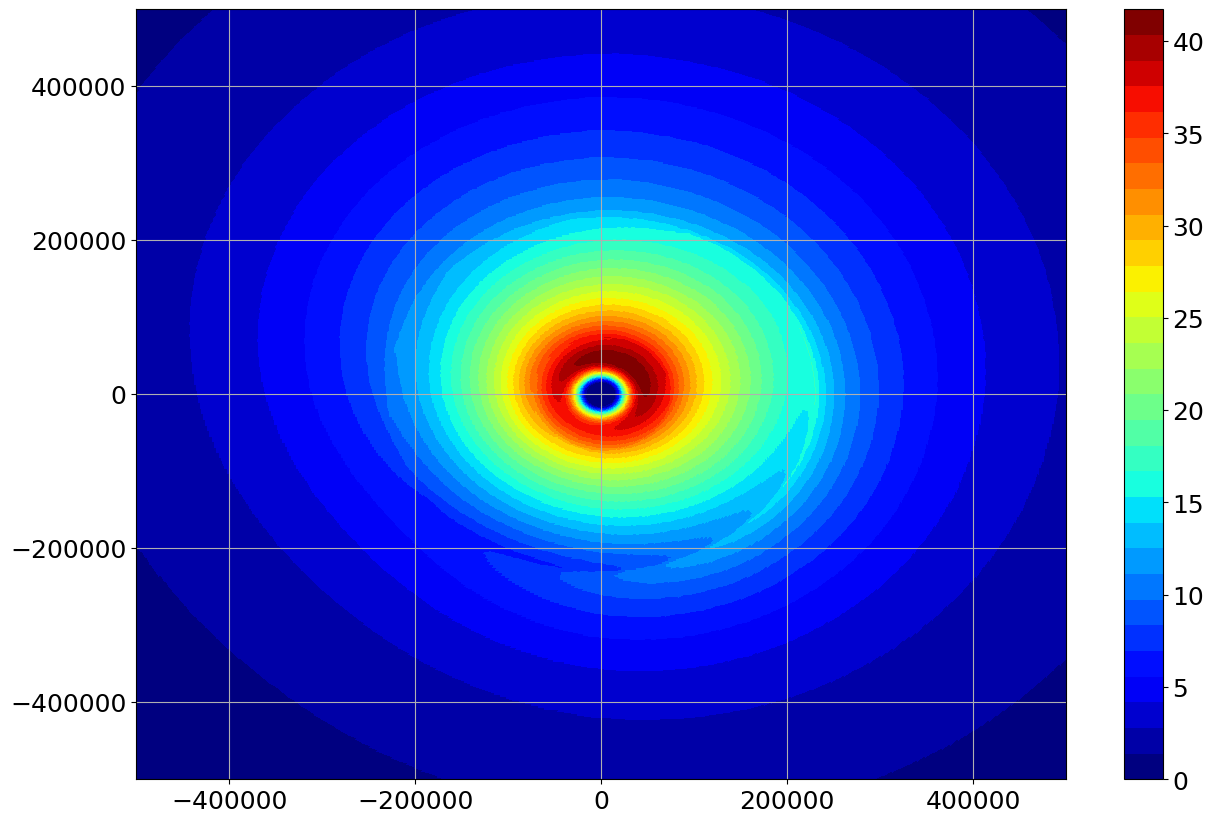

In [6]:
plt.pcolormesh(Xs, Ys, np.sqrt(Vs ** 2 + Us ** 2), cmap=cm.get_cmap('jet', 30));plt.colorbar()
plt.grid();plt.xlim(-5e5, 5e5);plt.ylim(-5e5, 5e5)

/tmp/ipykernel_7896/4106776672.py:1: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(Xs, Ys, Vs, cmap=cm.get_cmap('jet', 30));plt.colorbar()


(-500000.0, 500000.0)

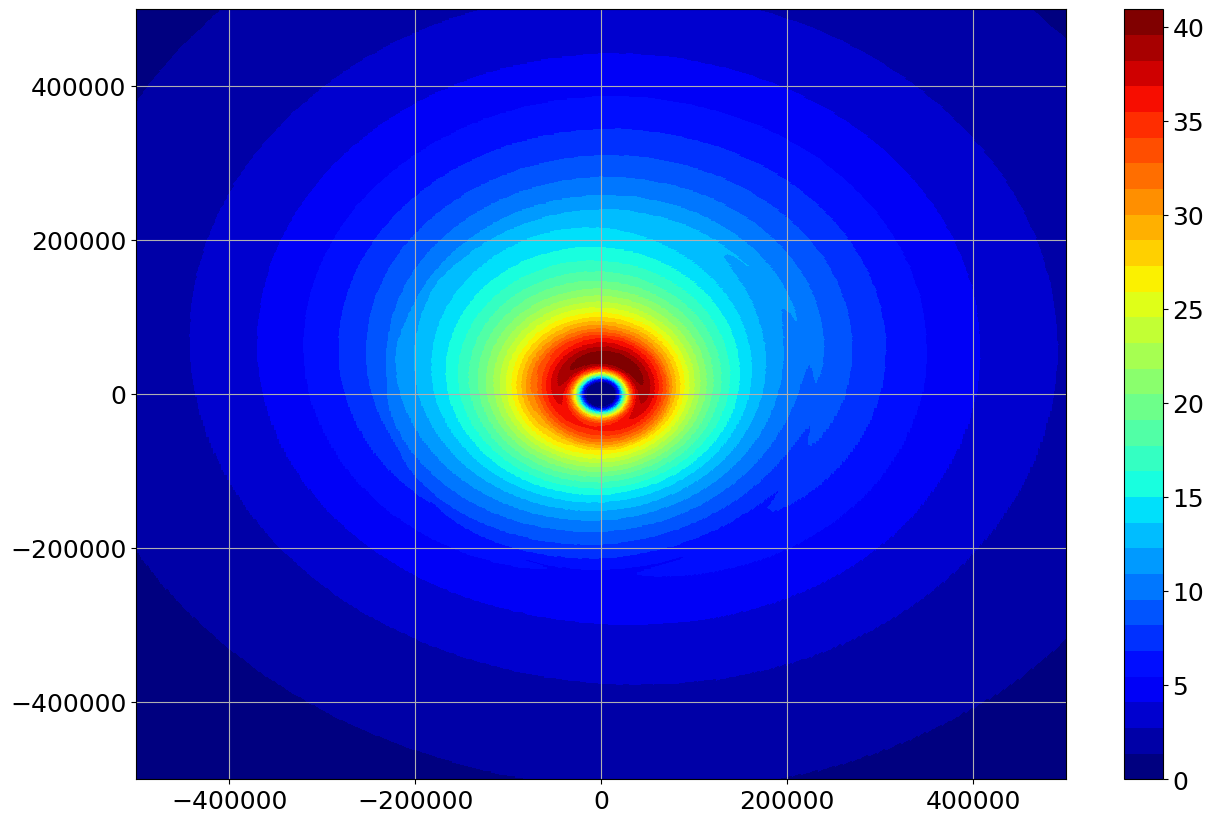

In [7]:
plt.pcolormesh(Xs, Ys, Vs, cmap=cm.get_cmap('jet', 30));plt.colorbar()
plt.grid();plt.xlim(-5e5, 5e5);plt.ylim(-5e5, 5e5)

/tmp/ipykernel_7896/3244345685.py:1: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(Xs, Ys, Us, cmap=cm.get_cmap('jet', 30));plt.colorbar()


(-500000.0, 500000.0)

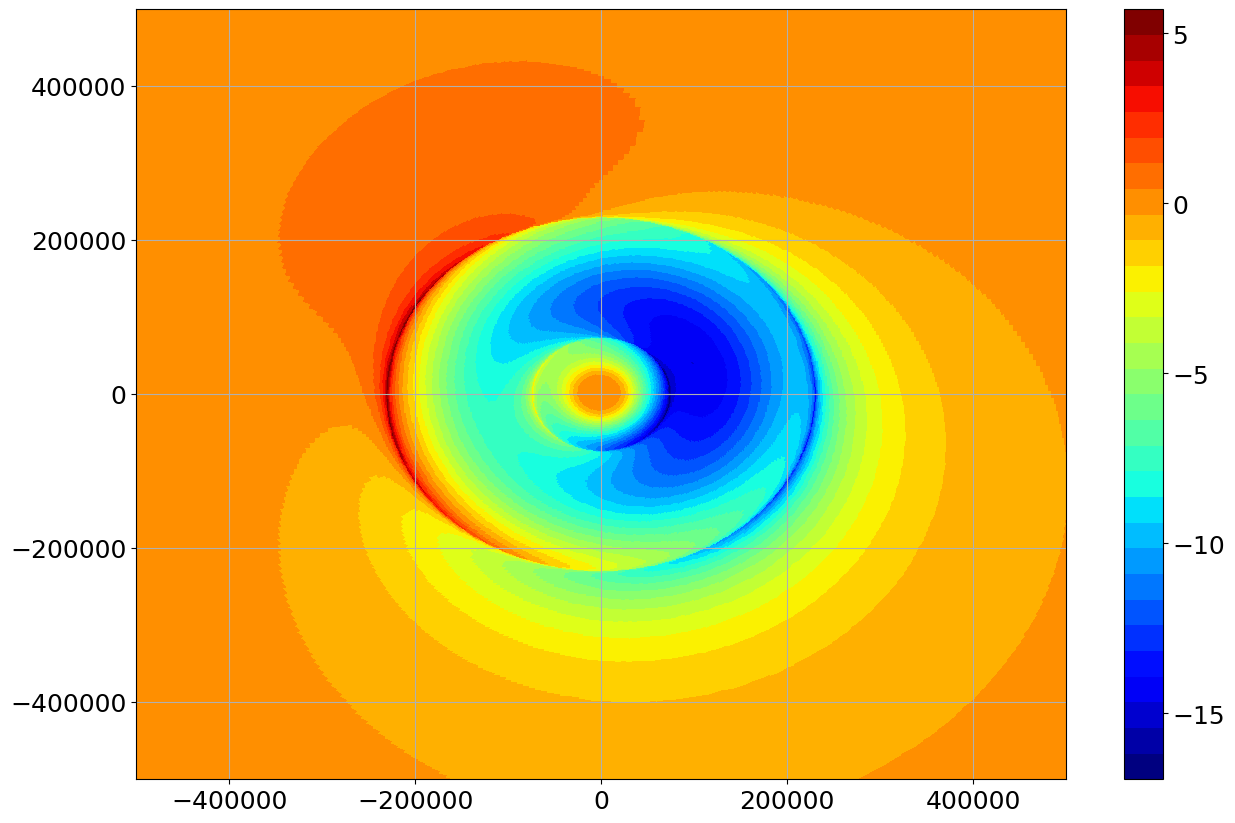

In [61]:
plt.pcolormesh(Xs, Ys, Us, cmap=cm.get_cmap('jet', 30));plt.colorbar()
plt.grid();plt.xlim(-5e5, 5e5);plt.ylim(-5e5, 5e5)

0it [00:00, ?it/s]

/tmp/ipykernel_7896/1755157264.py:15: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im = ax.pcolormesh(Xs / 1000, Ys / 1000, np.sqrt(Vs ** 2 + Us ** 2), cmap=cmap, norm=normalizer)


0it [00:00, ?it/s]

0it [00:00, ?it/s]

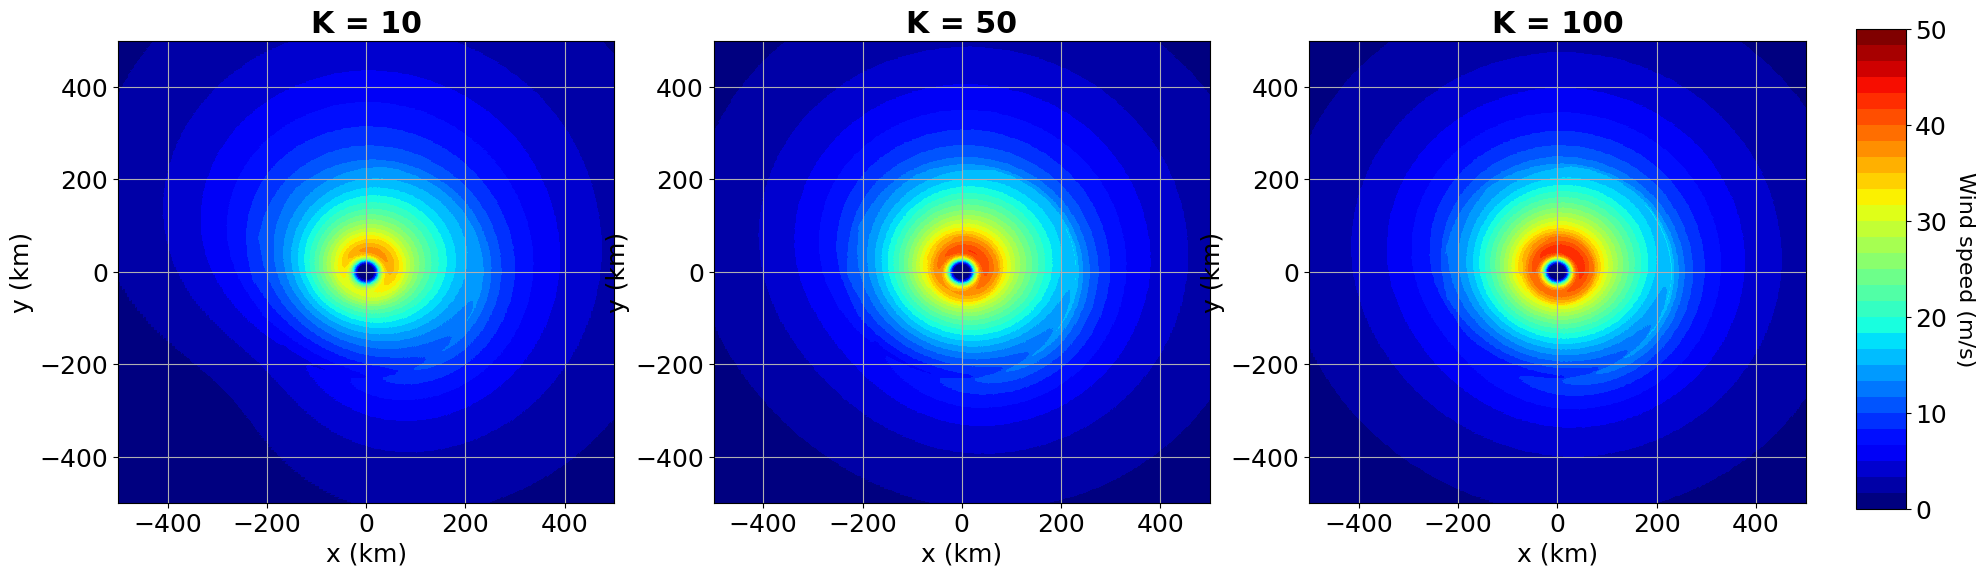

In [9]:
### VARIATIONS IN K
cmap       = cm.get_cmap('jet', 30)
normalizer = Normalize(0, 50)
im         = cm.ScalarMappable(norm=normalizer)
fig, axs   = plt.subplots(nrows=1, ncols=3, figsize=(25, 6))

for K, ax in zip([10, 50, 100], axs):
    Us = np.ones_like(Rs)
    Vs = np.ones_like(Rs)
    for i, th in tqdm(enumerate(ths)):
        Us[i, :] = u_BL(th, rs, V, Ut, K, C, fcor)
        Vs[i, :] = v_BL(th, rs, V, Ut, K, C, fcor)
        
    ax.set_title('K = {}'.format(K), weight='bold')
    im = ax.pcolormesh(Xs / 1000, Ys / 1000, np.sqrt(Vs ** 2 + Us ** 2), cmap=cmap, norm=normalizer)
    ax.grid();ax.set_xlim(-500, 500);ax.set_ylim(-500, 500);ax.set_xlabel('x (km)');ax.set_ylabel('y (km)')
    
# Colorbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.1, 0.02, 0.8])
cbar    = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('Wind speed (m/s)', rotation=270, fontsize=16)
cbar.ax.get_yaxis().labelpad=20

0it [00:00, ?it/s]

/tmp/ipykernel_7896/3608066267.py:17: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im = ax.pcolormesh(Xs / 1000, Ys / 1000, np.sqrt(Vs ** 2 + Us ** 2), cmap=cmap, norm=normalizer)


0it [00:00, ?it/s]

0it [00:00, ?it/s]

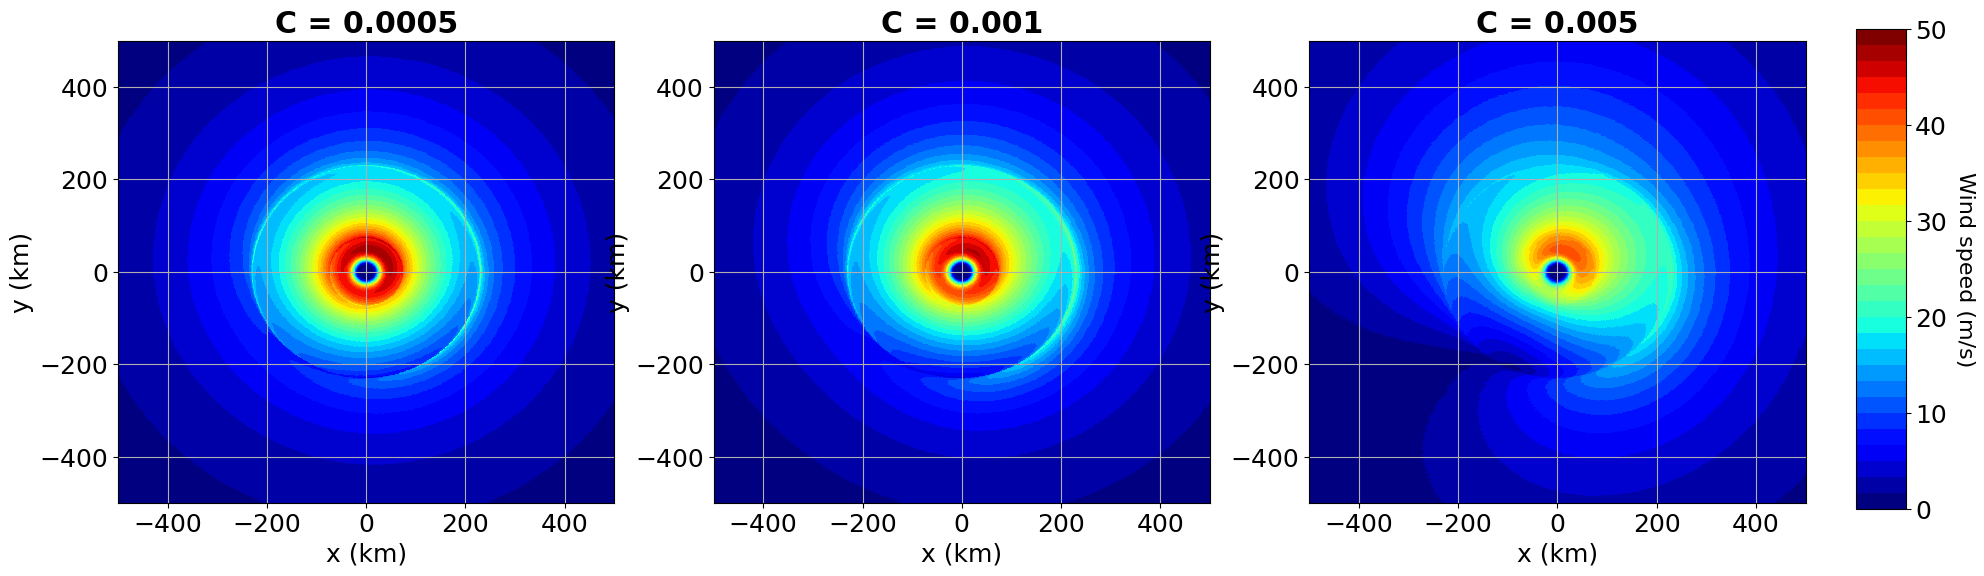

In [34]:
### VARIATIONS IN C
K = 50

cmap       = cm.get_cmap('jet', 30)
normalizer = Normalize(0, 50)
im         = cm.ScalarMappable(norm=normalizer)
fig, axs   = plt.subplots(nrows=1, ncols=3, figsize=(25, 6))

for C, ax in zip([5e-4, 1e-3, 5e-3], axs):
    Us = np.ones_like(Rs)
    Vs = np.ones_like(Rs)
    for i, th in tqdm(enumerate(ths)):
        Us[i, :] = u_BL(th, rs, V, Ut, K, C, fcor)
        Vs[i, :] = v_BL(th, rs, V, Ut, K, C, fcor)
        
    ax.set_title('C = {}'.format(C), weight='bold')
    im = ax.pcolormesh(Xs / 1000, Ys / 1000, np.sqrt(Vs ** 2 + Us ** 2), cmap=cmap, norm=normalizer)
    ax.grid();ax.set_xlim(-500, 500);ax.set_ylim(-500, 500);ax.set_xlabel('x (km)');ax.set_ylabel('y (km)')
    
# Colorbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.1, 0.02, 0.8])
cbar    = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('Wind speed (m/s)', rotation=270, fontsize=16)
cbar.ax.get_yaxis().labelpad=20

In [36]:
# for C in [5e-4, 1e-3, 5e-3]:
#     Us = np.ones_like(Rs)
#     Vs = np.ones_like(Rs)
#     for i, th in tqdm(enumerate(ths)):
#         Us[i, :] = u_BL(th, rs, V, Ut, K, C, fcor)
#         Vs[i, :] = v_BL(th, rs, V, Ut, K, C, fcor)
        
#     print(C, K, Ut)        
#     U_prof = np.mean(Us, axis=0)
#     V_prof = np.mean(Vs, axis=0)
#     plt.plot(rs, V, c='k', linewidth=3, label='Holland')
#     plt.plot(rs, V_prof, c='tab:blue', label='v BL')
#     plt.plot(rs, -U_prof, c='tab:orange', label='-u BL')
#     plt.plot(rs, 30 * (-U_prof / V_prof), c='purple', linestyle='--', label='30 * tan a')
#     plt.grid();plt.legend();plt.show()

0it [00:00, ?it/s]

/tmp/ipykernel_7896/1979699343.py:18: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im = ax.pcolormesh(Xs / 1000, Ys / 1000, np.sqrt(Vs ** 2 + Us ** 2), cmap=cmap, norm=normalizer)


0it [00:00, ?it/s]

0it [00:00, ?it/s]

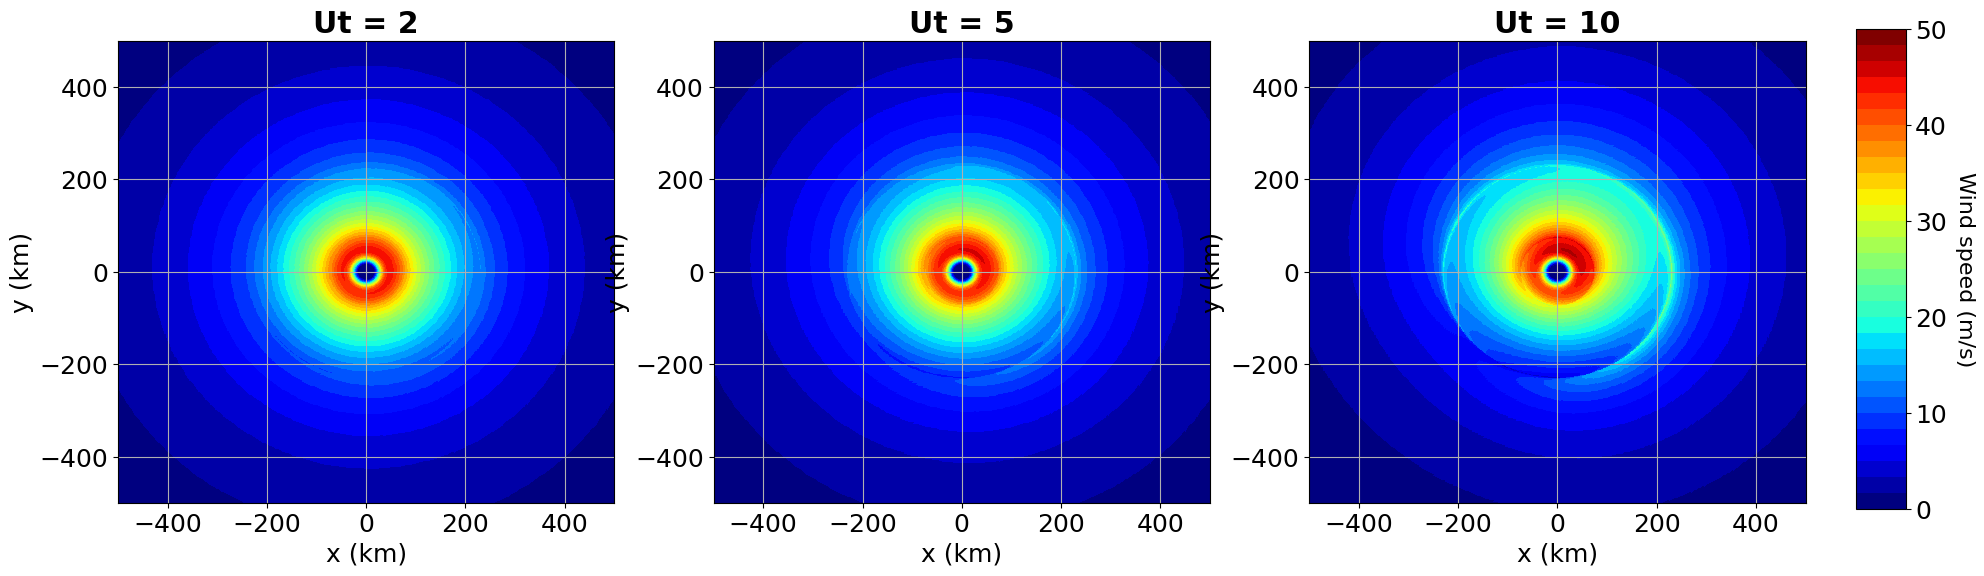

In [11]:
### VARIATIONS IN Ut
K = 50
C = 1e-3

cmap       = cm.get_cmap('jet', 30)
normalizer = Normalize(0, 50)
im         = cm.ScalarMappable(norm=normalizer)
fig, axs   = plt.subplots(nrows=1, ncols=3, figsize=(25, 6))

for Ut, ax in zip([2, 5, 10], axs):
    Us = np.ones_like(Rs)
    Vs = np.ones_like(Rs)
    for i, th in tqdm(enumerate(ths)):
        Us[i, :] = u_BL(th, rs, V, Ut, K, C, fcor)
        Vs[i, :] = v_BL(th, rs, V, Ut, K, C, fcor)
        
    ax.set_title('Ut = {}'.format(Ut), weight='bold')
    im = ax.pcolormesh(Xs / 1000, Ys / 1000, np.sqrt(Vs ** 2 + Us ** 2), cmap=cmap, norm=normalizer)
    ax.grid();ax.set_xlim(-500, 500);ax.set_ylim(-500, 500);ax.set_xlabel('x (km)');ax.set_ylabel('y (km)')
    
# Colorbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.1, 0.02, 0.8])
cbar    = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('Wind speed (m/s)', rotation=270, fontsize=16)
cbar.ax.get_yaxis().labelpad=20

0it [00:00, ?it/s]

0.001 50 2


/tmp/ipykernel_7896/2579951222.py:14: RuntimeWarning: invalid value encountered in divide
  plt.plot(rs, 30 * (-U_prof / V_prof), c='purple', linestyle='--', label='30 * tan a')


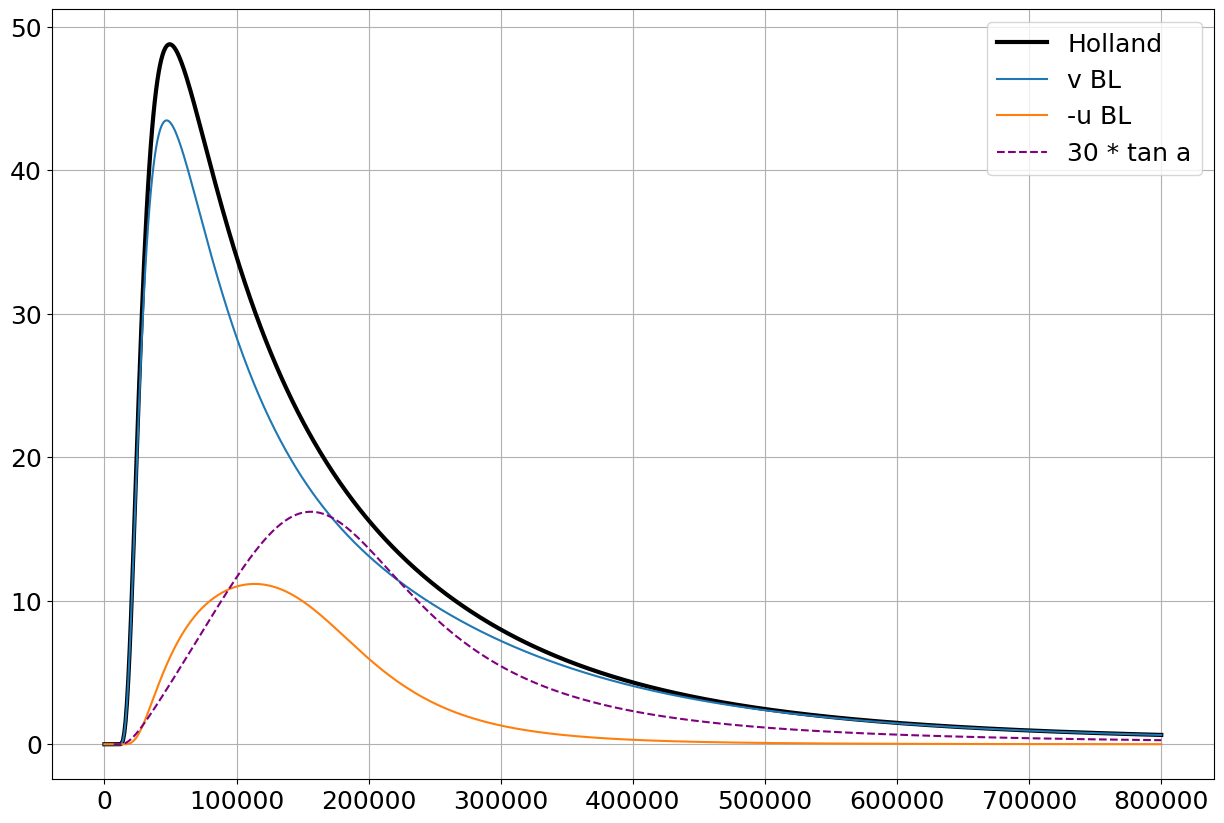

0it [00:00, ?it/s]

0.001 50 5


/tmp/ipykernel_7896/2579951222.py:14: RuntimeWarning: invalid value encountered in divide
  plt.plot(rs, 30 * (-U_prof / V_prof), c='purple', linestyle='--', label='30 * tan a')


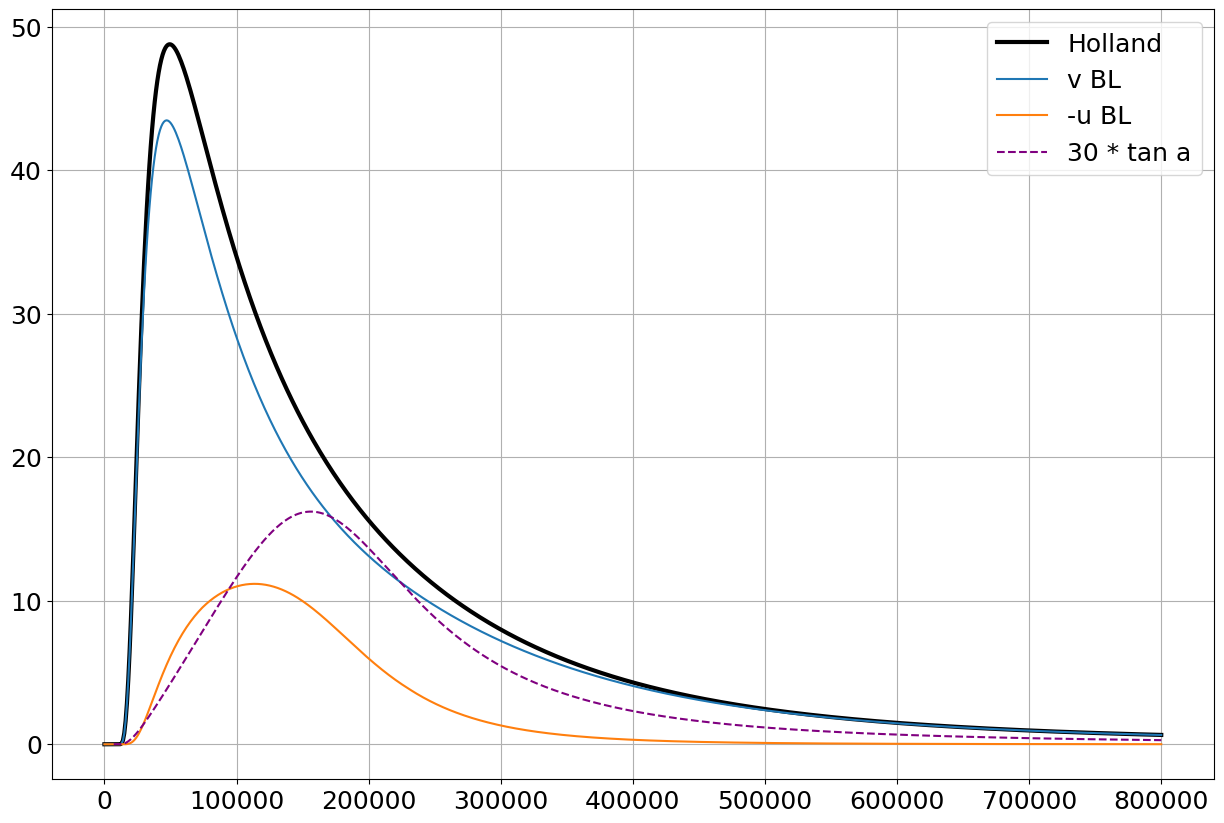

0it [00:00, ?it/s]

0.001 50 10


/tmp/ipykernel_7896/2579951222.py:14: RuntimeWarning: invalid value encountered in divide
  plt.plot(rs, 30 * (-U_prof / V_prof), c='purple', linestyle='--', label='30 * tan a')


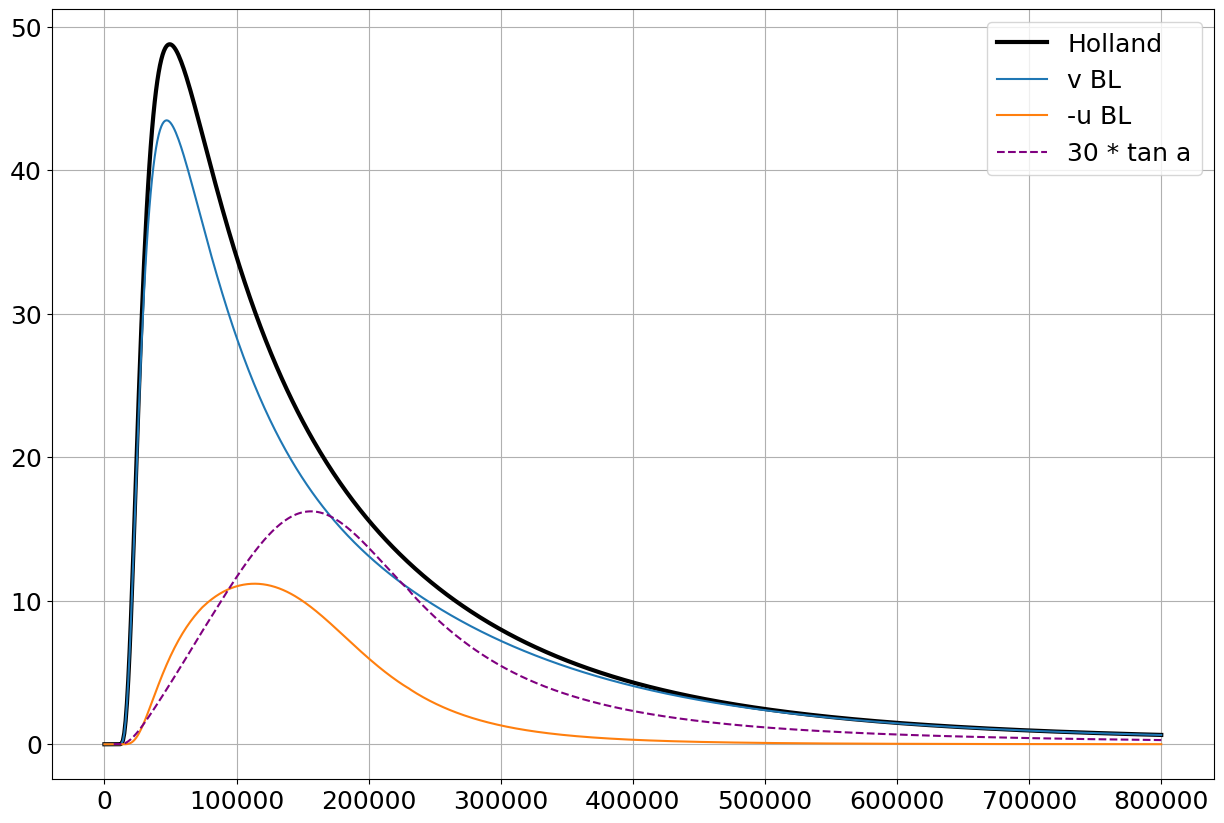

In [33]:
for Ut in [2, 5, 10]:
    Us = np.ones_like(Rs)
    Vs = np.ones_like(Rs)
    for i, th in tqdm(enumerate(ths)):
        Us[i, :] = u_BL(th, rs, V, Ut, K, C, fcor)
        Vs[i, :] = v_BL(th, rs, V, Ut, K, C, fcor)
        
    print(C, K, Ut)        
    U_prof = np.mean(Us, axis=0)
    V_prof = np.mean(Vs, axis=0)
    plt.plot(rs, V, c='k', linewidth=3, label='Holland')
    plt.plot(rs, V_prof, c='tab:blue', label='v BL')
    plt.plot(rs, -U_prof, c='tab:orange', label='-u BL')
    plt.plot(rs, 30 * (-U_prof / V_prof), c='purple', linestyle='--', label='30 * tan a')
    plt.grid();plt.legend();plt.show()

0it [00:00, ?it/s]

0.001 50 5


/tmp/ipykernel_7896/1664470712.py:17: RuntimeWarning: invalid value encountered in divide
  plt.plot(rs, 30 * (-U_prof / V_prof), c='purple', linestyle='--', label='30 * tan a')


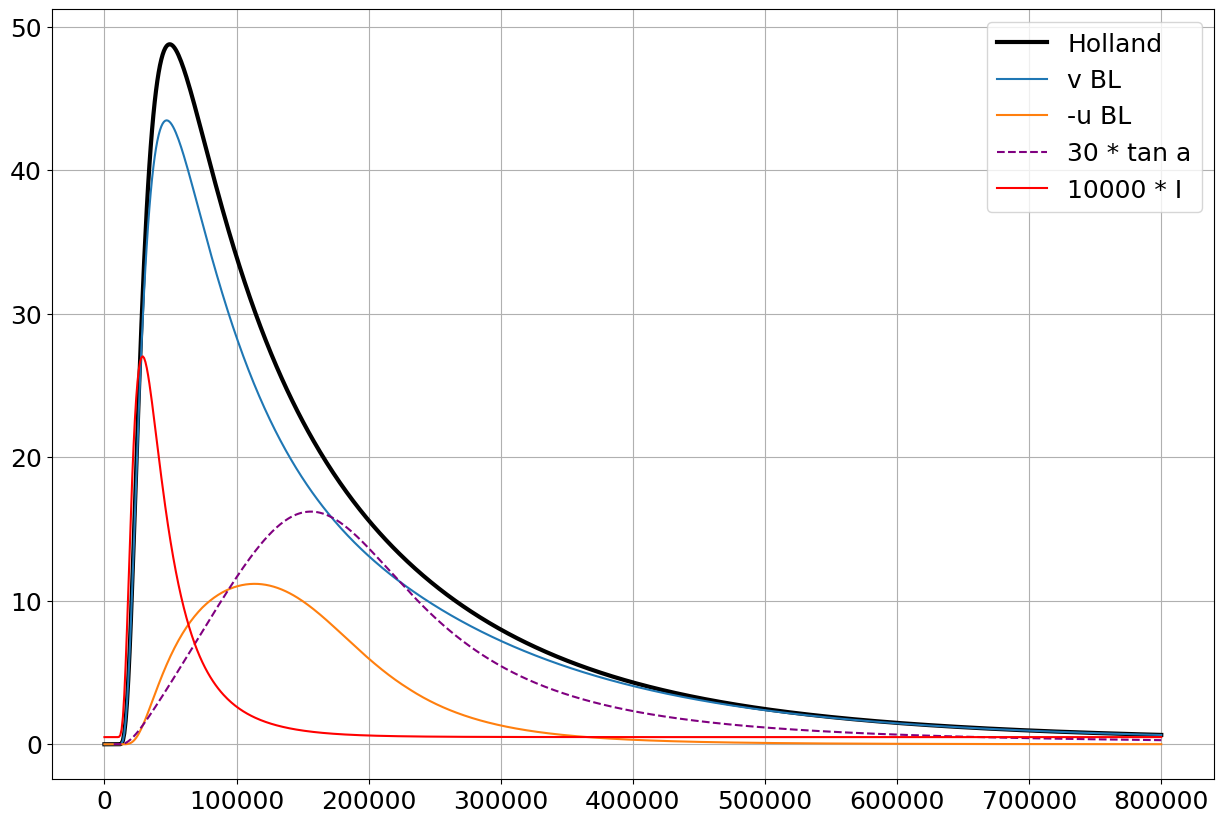

In [60]:
K  = 50
C  = 1e-3
Ut = 5

Us = np.ones_like(Rs)
Vs = np.ones_like(Rs)
for i, th in tqdm(enumerate(ths)):
    Us[i, :] = u_BL(th, rs, V, Ut, K, C, fcor)
    Vs[i, :] = v_BL(th, rs, V, Ut, K, C, fcor)

print(C, K, Ut)        
U_prof = np.mean(Us, axis=0)
V_prof = np.mean(Vs, axis=0)
plt.plot(rs, V, c='k', linewidth=3, label='Holland')
plt.plot(rs, V_prof, c='tab:blue', label='v BL')
plt.plot(rs, -U_prof, c='tab:orange', label='-u BL')
plt.plot(rs, 30 * (-U_prof / V_prof), c='purple', linestyle='--', label='30 * tan a')
plt.plot(rs, 10000 * I(rs, V, fcor), c='red', label='10000 * I')
plt.grid();plt.legend()

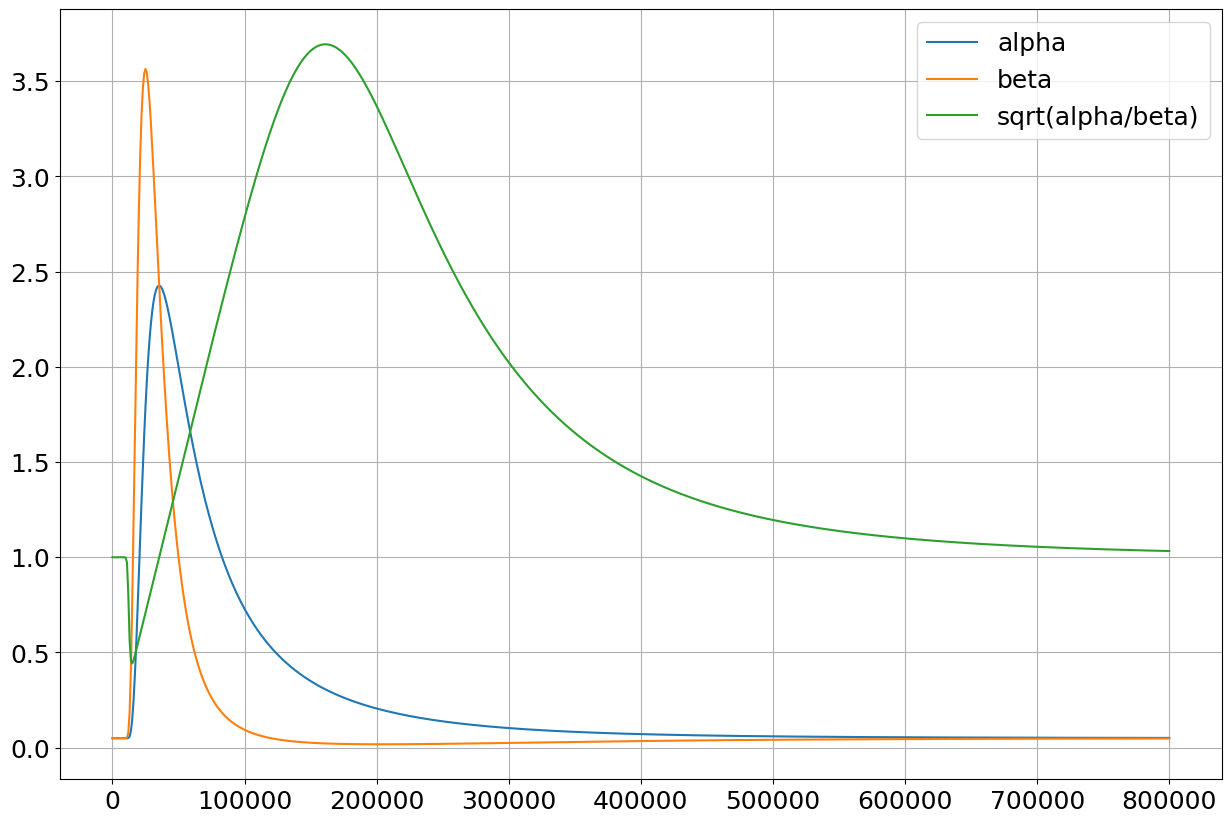

In [59]:
dr    = np.unique(np.diff(rs))[0]
alpha = 2 * V / rs + fcor
beta  = np.gradient(V, dr) + V / rs + fcor
plt.plot(rs, 1000 * alpha, label='alpha')
plt.plot(rs, 1000 * beta, label='beta')
plt.plot(rs, np.sqrt(alpha / beta), label='sqrt(alpha/beta)')
plt.grid();plt.legend()

In [12]:
# plt.plot(u0(rs, V, K, C, fcor))
# plt.plot(V + v0(rs, V, K, C, fcor))
# plt.plot(abs(u0(rs, V, K, C, fcor) / (V + v0(rs, V, K, C, fcor))))

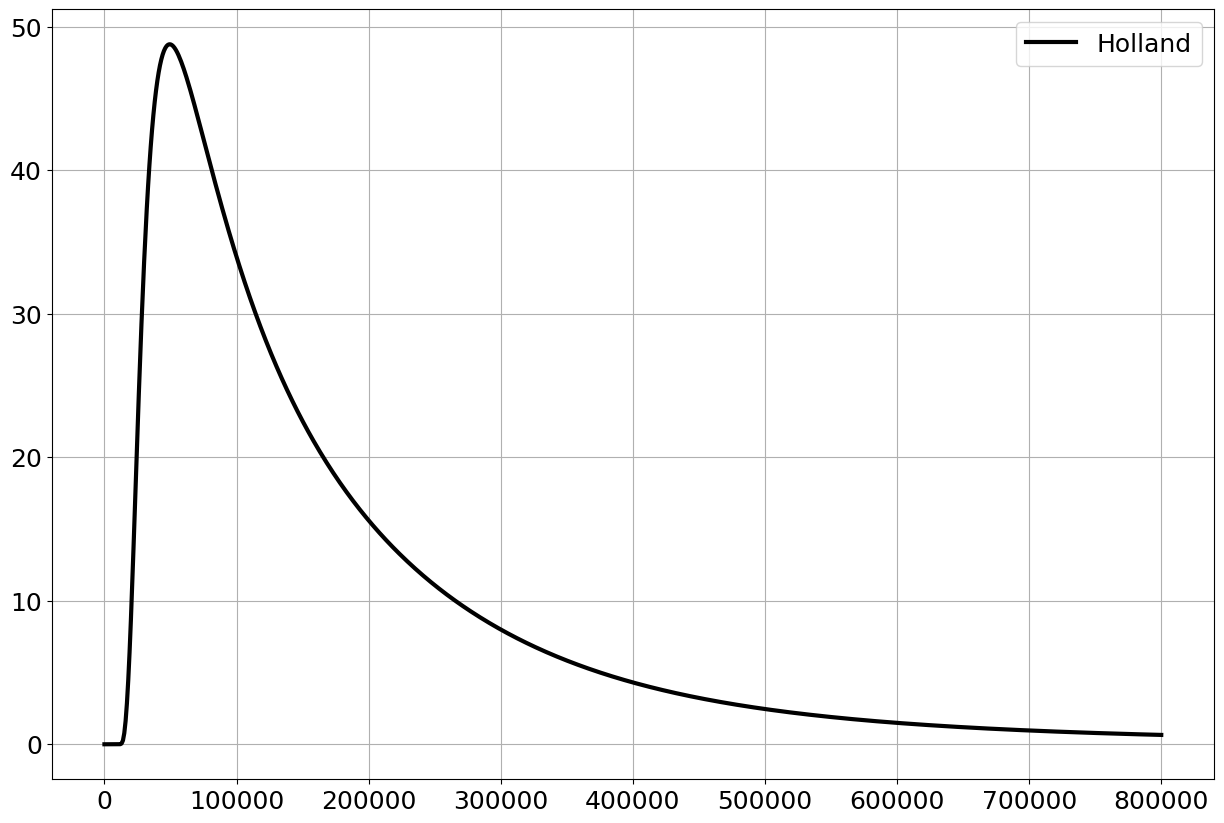

In [13]:
plt.plot(rs, V, c='k', linewidth=3, label='Holland')
# plt.plot(rs, v + v_prime(rs, v, fcor, Cd, K), c='tab:blue', label='v BL')
# plt.plot(rs, v + v_prime(rs, v, fcor, Cd, K2), c='tab:blue', label='v BL2', linestyle='--')
# # plt.plot(rs, v + v_prime(rs, v, fcor, Cd2, K), c='tab:blue', label='v BL2', linestyle='--')
# plt.plot(rs, -u(rs, v, fcor, Cd, K), c='tab:orange', label='-u BL')
# plt.plot(rs, 30 * (-u(rs, v, fcor, Cd, K) / (v + v_prime(rs, v, fcor, Cd, K))), c='purple', linestyle='--', label='tan a')
plt.grid();plt.legend()

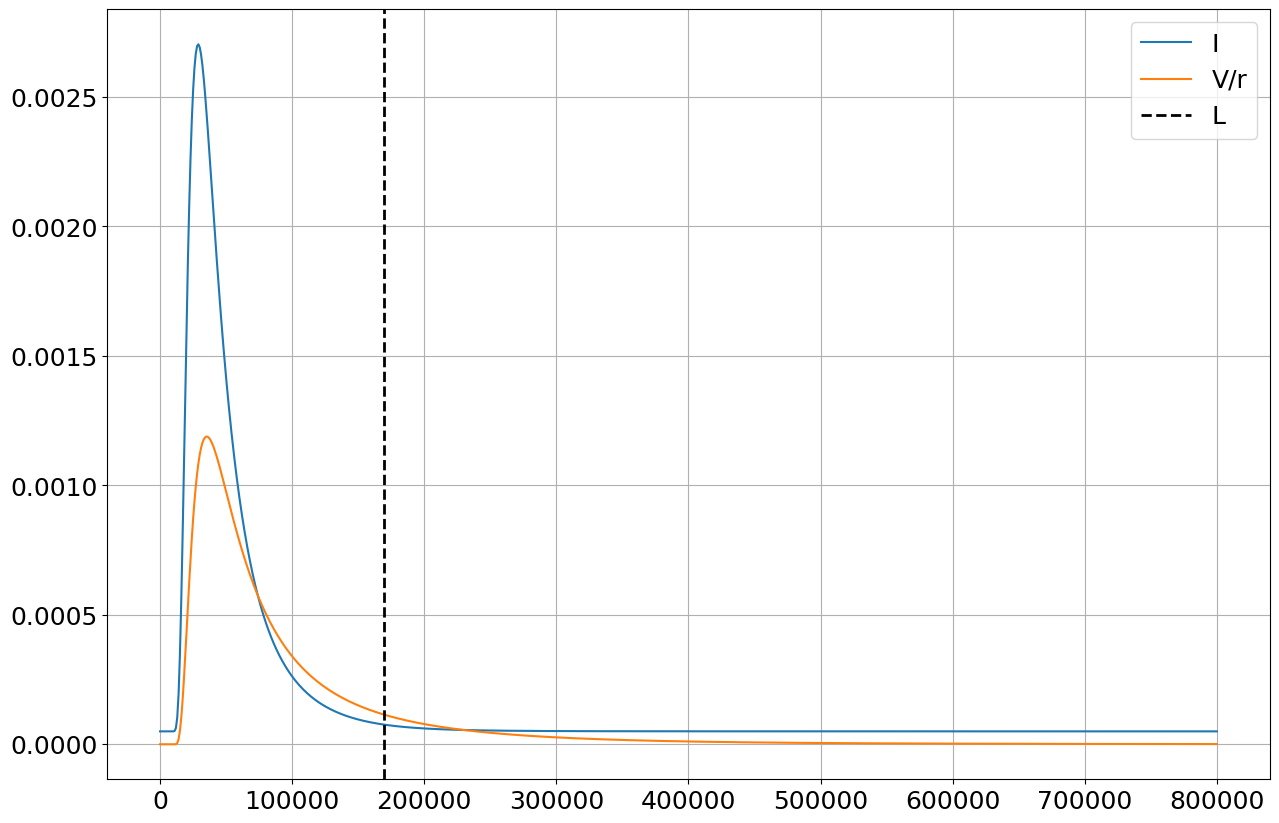

In [14]:
plt.plot(rs, I(rs, V, fcor), label='I')
plt.plot(rs, V / rs, label='V/r')

# Test
def vorticity(r, v):
    '''Relative vorticity'''
    dr = 1000 # meters
    return (1 / r) * np.gradient(r * v, dr)

q        = (rs * V ** 2) / (vorticity(rs, V) + fcor)
L        = rs[np.argmax(q)] # characteristic length

plt.axvline(L, c='k', linewidth=2, label='L', linestyle='--')
plt.grid();plt.legend()

# CONCLUSION: the radius where I = V/r is exactly the characteristic length L. 
# So the asymmetric form of v_BL contains information on L!

Text(0, 0.5, 'depth (m)')

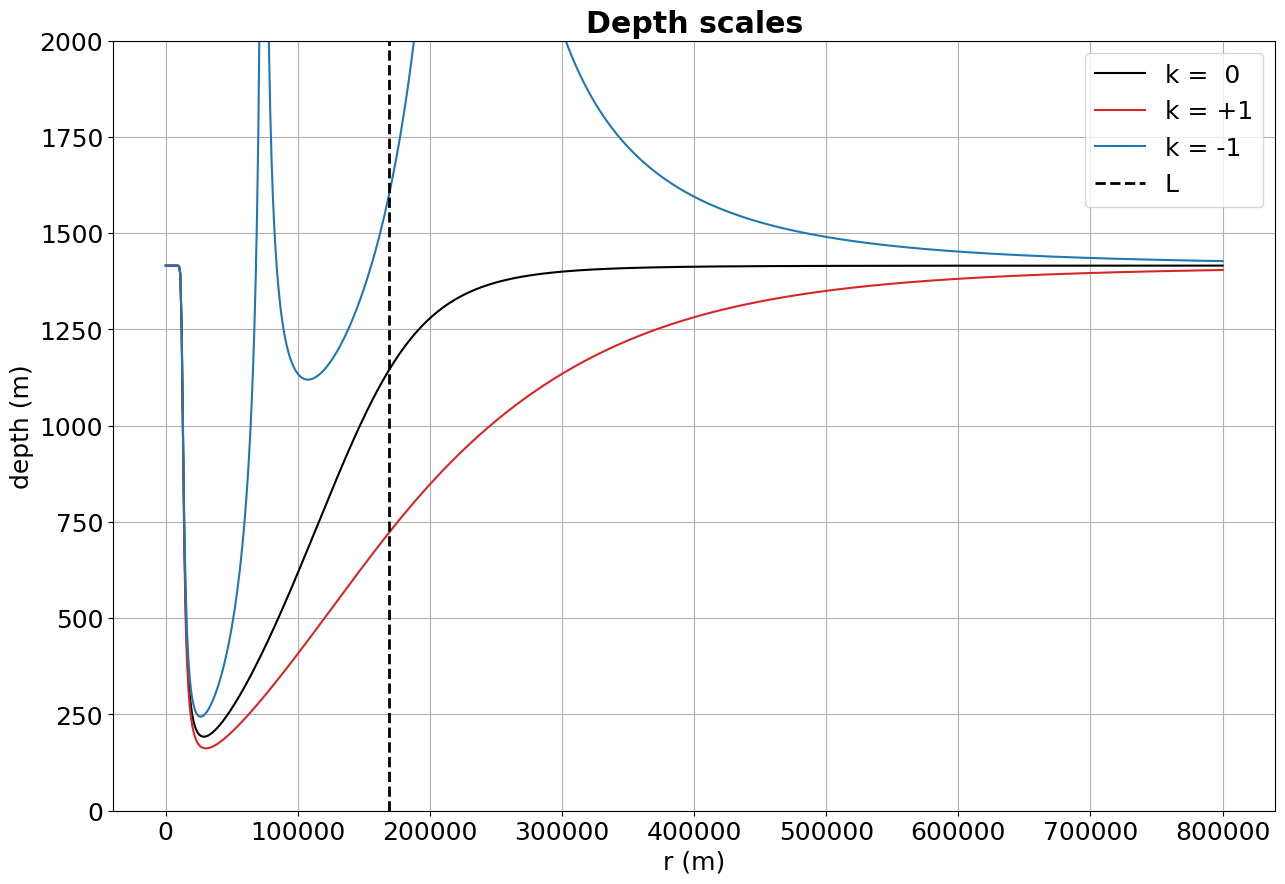

In [15]:
plt.title('Depth scales', weight='bold')
plt.plot(rs, np.sqrt( 2 * K / I(rs, V, fcor)),               label='k =  0', c='k')
plt.plot(rs, np.sqrt( 2 * K / abs(I(rs, V, fcor) + V / rs)), label='k = +1', c='tab:red')
plt.plot(rs, np.sqrt( 2 * K / abs(I(rs, V, fcor) - V / rs)), label='k = -1', c='tab:blue')
plt.axvline(L, c='k', linewidth=2, label='L', linestyle='--')
plt.ylim(0, 2000)
plt.grid();plt.legend()
plt.xlabel('r (m)');plt.ylabel('depth (m)')

### Add storm vector

In [73]:
### Adding storm vector
K  = 50
C  = 1e-3
Ut = 5

# ths     = np.linspace(0, 2 * np.pi, 361)
# Rs, THs = np.meshgrid(rs, ths)
# print(Rs.shape)
Us = np.ones_like(Rs)
Vs = np.ones_like(Rs)

for i, th in tqdm(enumerate(ths)):
    # print(i, th)
    Us[i, :] = u_BL(th, rs, V, Ut, K, C, fcor)
    Vs[i, :] = v_BL(th, rs, V, Ut, K, C, fcor)
    
# Add storm speed vector
Us = Us + Ut * np.cos(THs)
Vs = Vs - Ut * np.sin(THs)

Xs, Ys = pol2cart(Rs, THs)

0it [00:00, ?it/s]

/tmp/ipykernel_7896/3554317365.py:1: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(Xs, Ys, np.sqrt(Vs ** 2 + Us ** 2), cmap=cm.get_cmap('jet', 30));plt.colorbar()


(-500000.0, 500000.0)

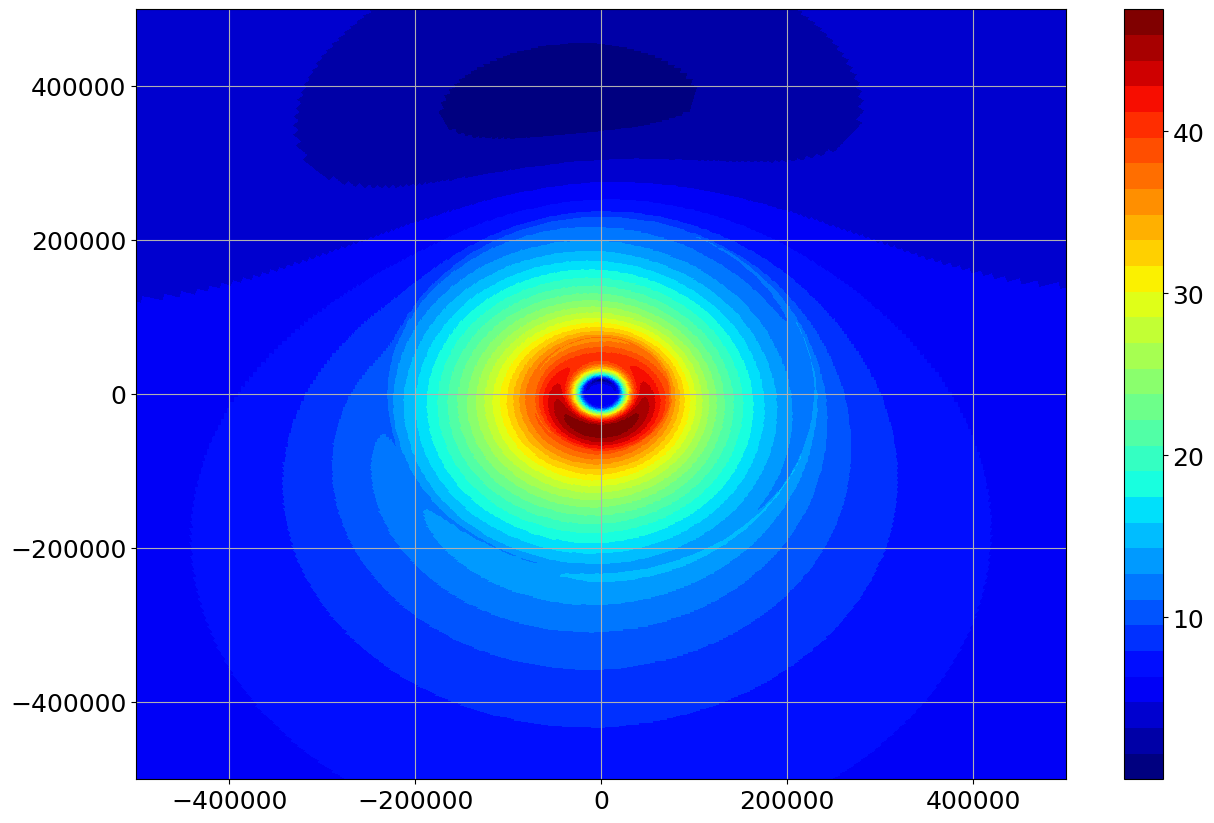

In [74]:
plt.pcolormesh(Xs, Ys, np.sqrt(Vs ** 2 + Us ** 2), cmap=cm.get_cmap('jet', 30));plt.colorbar()
plt.grid();plt.xlim(-5e5, 5e5);plt.ylim(-5e5, 5e5)

/tmp/ipykernel_7896/3553955705.py:8: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im = ax.pcolormesh(Xs / 1000, Ys / 1000, wind, cmap=cm.get_cmap('jet', 30))


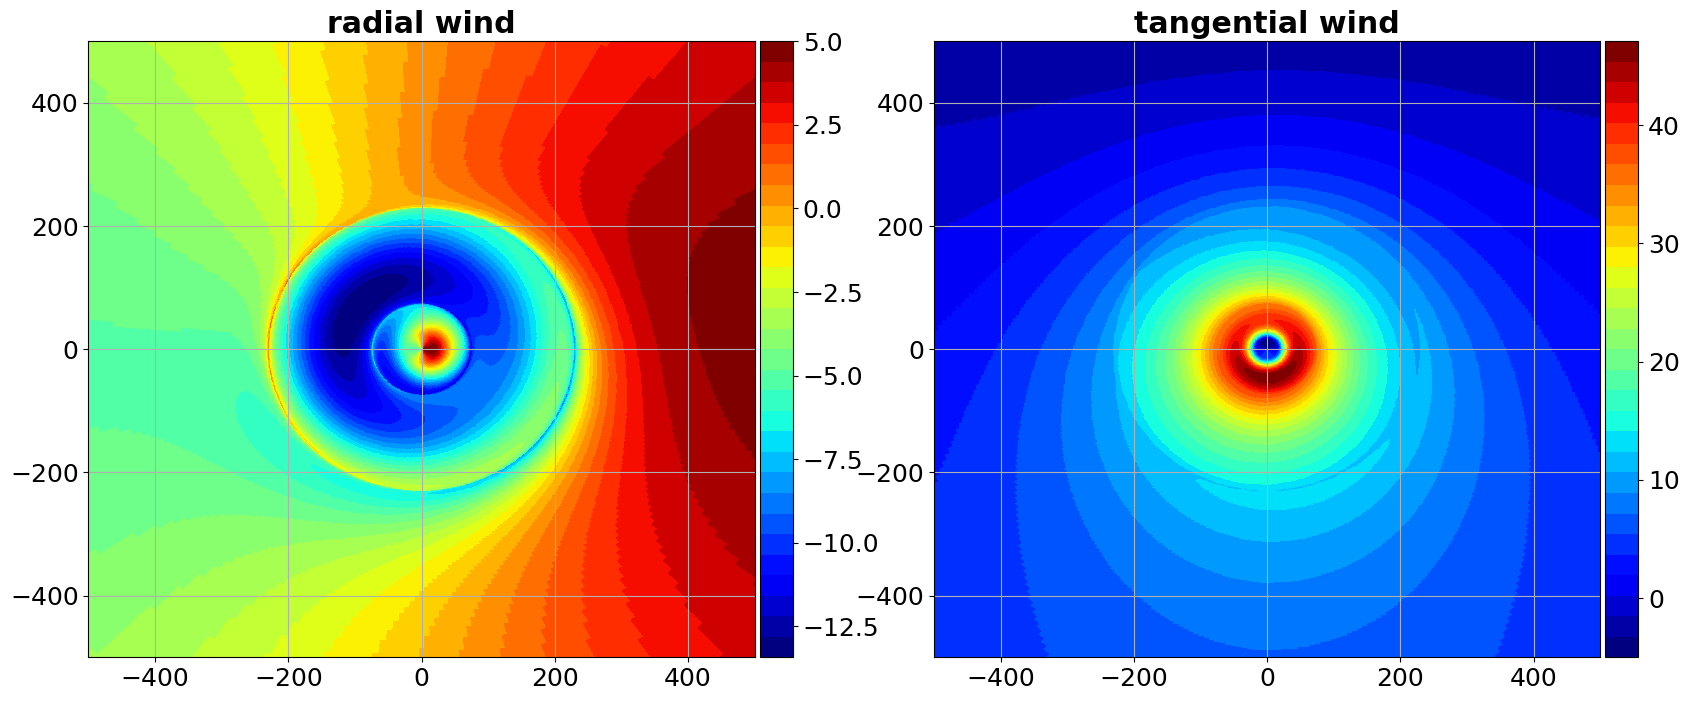

In [82]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

for ax, wind, title in zip(axs, [Us, Vs], ['radial', 'tangential']):
    ax.set_title('{} wind'.format(title), weight='bold')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    im = ax.pcolormesh(Xs / 1000, Ys / 1000, wind, cmap=cm.get_cmap('jet', 30))
    fig.colorbar(im, cax=cax, orientation='vertical')
    ax.grid();ax.set_xlim(-500, 500);ax.set_ylim(-500, 500)

### Test with SAR: different Bs

In [83]:
dsg = xr.open_dataset('/home/arthur/data/cyclobs/SAR_compilations_in_nc/SAR_centered_rotated_files_13052022_with_extra_params.nc')

/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/lib-dynload/../../libffi.so.8: version `LIBFFI_CLOSURE_7.0' not found (required by /home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/_cffi_backend.cpython-38-x86_64-linux-gnu.so)
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [290]:
d = dsg.where((dsg.Vmax_1D > 50) & (dsg.Vmax_1D <= 55), drop=True)
d = d.where((d.cyclone_speed > 4.5) & (d.cyclone_speed <= 5.5), drop=True)
print(d.B_hol.data)
print(d.cyclone_speed.data)
print(d.lat_center.data)

[2.19945453 1.21796338 2.29973522 1.45031474 0.93531399 2.10485722
 1.85483458 1.55899766]
[5.21624264 4.77610613 5.36368234 4.66682123 4.57165521 4.63409027
 5.00696906 4.95795789]
[16.63790877 23.47674955 15.02081503 17.26540553 19.8195685  25.25236518
 17.41660436 21.5284393 ]


In [297]:
d_hgh = d.isel(time=5) # High Holland B
print(d_hgh.sat_file.item())
print('B     = {:.2f}'.format(d_hgh.B_hol))
print('Speed = {:.2f}'.format(d_hgh.cyclone_speed))
print('Vmax  = {:.1f}'.format(d_hgh.Vmax_1D))
print('Rmax  = {:.1f}'.format(d_hgh.Rmax_1D))
print('Lat   = {:.1f}'.format(d_hgh.lat_center))

s1a-iw-owi-cm-20190830t224548-20190830t224705-000003-03435D_sw.nc
B     = 2.10
Speed = 4.63
Vmax  = 52.9
Rmax  = 14.0
Lat   = 25.3


In [298]:
d_low = d.isel(time=1) # Low Holland B
print(d_low.sat_file.item())
print('B     = {:.2f}'.format(d_low.B_hol))
print('Speed = {:.2f}'.format(d_low.cyclone_speed))
print('Vmax  = {:.1f}'.format(d_low.Vmax_1D))
print('Rmax  = {:.1f}'.format(d_low.Rmax_1D))
print('Lat   = {:.1f}'.format(d_low.lat_center))

s1a-ew-owi-cm-20200904t210200-20200904t210504-000003-03F9A9_sw.nc
B     = 1.22
Speed = 4.78
Vmax  = 50.3
Rmax  = 23.0
Lat   = 23.5


/tmp/ipykernel_7896/2797351109.py:8: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im = ax.pcolormesh(X_SAR / 1000, Y_SAR / 1000, ds.wind_speed.transpose(), cmap=cm.get_cmap('jet', 12), vmin=10, vmax=70)


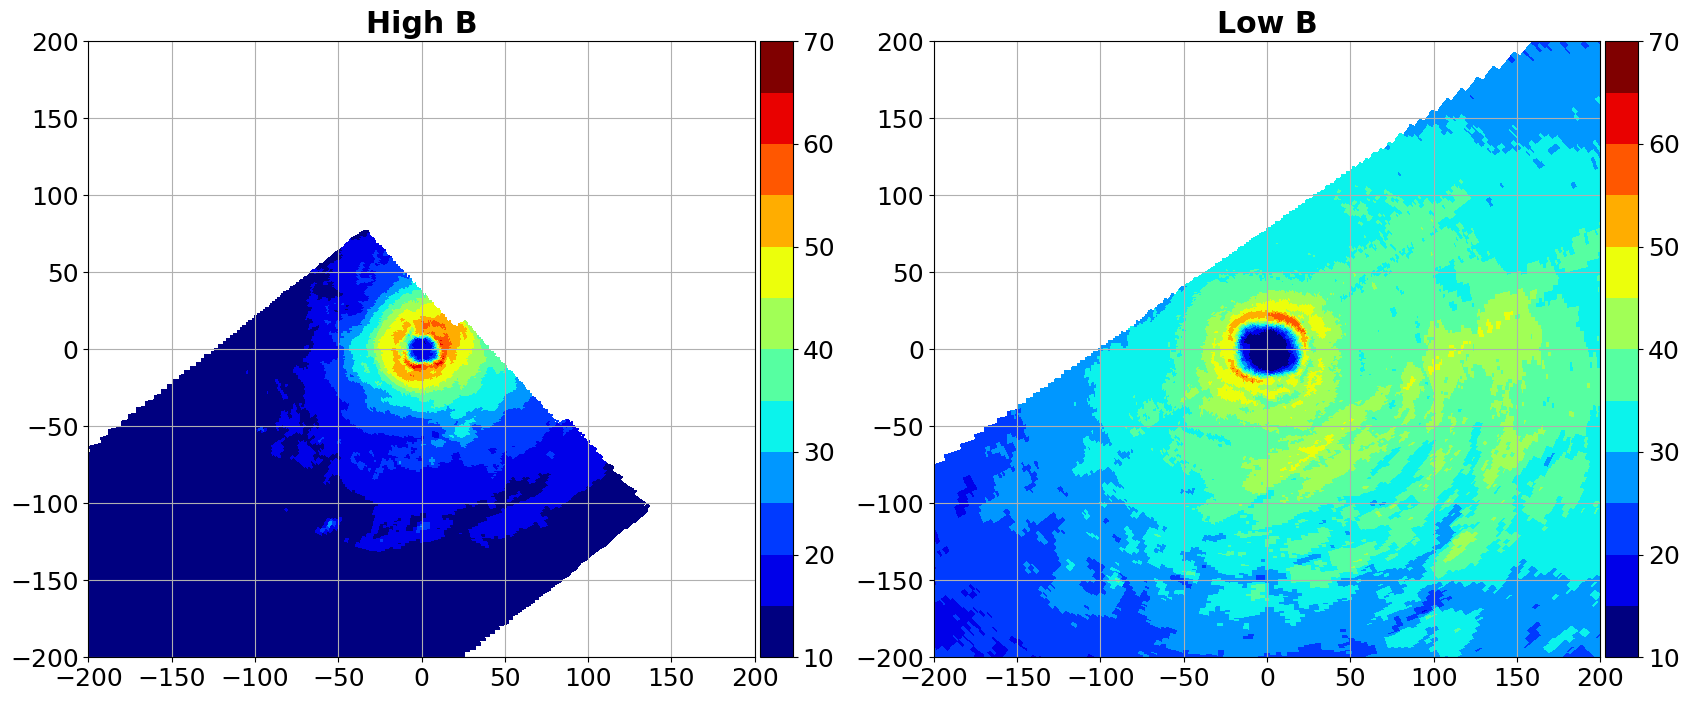

In [343]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

for ax, ds, title in zip(axs, [d_hgh, d_low], ['High', 'Low']):
    ax.set_title('{} B'.format(title), weight='bold')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    
    im = ax.pcolormesh(X_SAR / 1000, Y_SAR / 1000, ds.wind_speed.transpose(), cmap=cm.get_cmap('jet', 12), vmin=10, vmax=70)
    fig.colorbar(im, cax=cax, orientation='vertical')
    ax.grid();ax.set_xlim(-200, 200);ax.set_ylim(-200, 200)
    # ax.grid();ax.set_xlim(-500, 500);ax.set_ylim(-500, 500)

In [252]:
# R_SAR, TH_SAR = np.meshgrid(d_hgh.rad, np.pi / 2 - np.deg2rad(d_hgh.theta))
# X_SAR, Y_SAR  = pol2cart(R_SAR, TH_SAR)
# plt.pcolormesh(X_SAR, Y_SAR, d_hgh.wind_speed.transpose(), cmap=cm.get_cmap('jet', 30));plt.colorbar()
# plt.grid();plt.xlim(-5e5, 5e5);plt.ylim(-5e5, 5e5)

In [341]:
V_hgh = h80(rs, vm=52.9, rm=14000, B=2.1, lat=25)
V_low = h80(rs, vm=52.9, rm=14000, B=1.22, lat=25) 

### Adding storm vector
K      = 50
C      = 1e-3
Ut     = 4.7
fcor   = coriolis(25)   

Us_low = np.ones_like(Rs)
Vs_low = np.ones_like(Rs)
Us_hgh = np.ones_like(Rs)
Vs_hgh = np.ones_like(Rs)

for i, th in tqdm(enumerate(ths)):
    Us_low[i, :] = u_BL(th, rs, V_low, Ut, K, C, fcor)
    Vs_low[i, :] = v_BL(th, rs, V_low, Ut, K, C, fcor)
    Us_hgh[i, :] = u_BL(th, rs, V_hgh, Ut, K, C, fcor)
    Vs_hgh[i, :] = v_BL(th, rs, V_hgh, Ut, K, C, fcor)
    
# Add storm speed vector
Us_low = Us_low + Ut * np.cos(THs)
Vs_low = Vs_low - Ut * np.sin(THs)
Us_hgh = Us_hgh + Ut * np.cos(THs)
Vs_hgh = Vs_hgh - Ut * np.sin(THs)

Xs_hol, Ys_hol = pol2cart(Rs, THs + np.pi/2) # Rotation at 90° to make the cyclone going northward

0it [00:00, ?it/s]

/tmp/ipykernel_7896/1916485040.py:8: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im = ax.pcolormesh(Xs_hol / 1000, Ys_hol / 1000, V_total, cmap=cm.get_cmap('jet', 12), vmin=0, vmax=60)


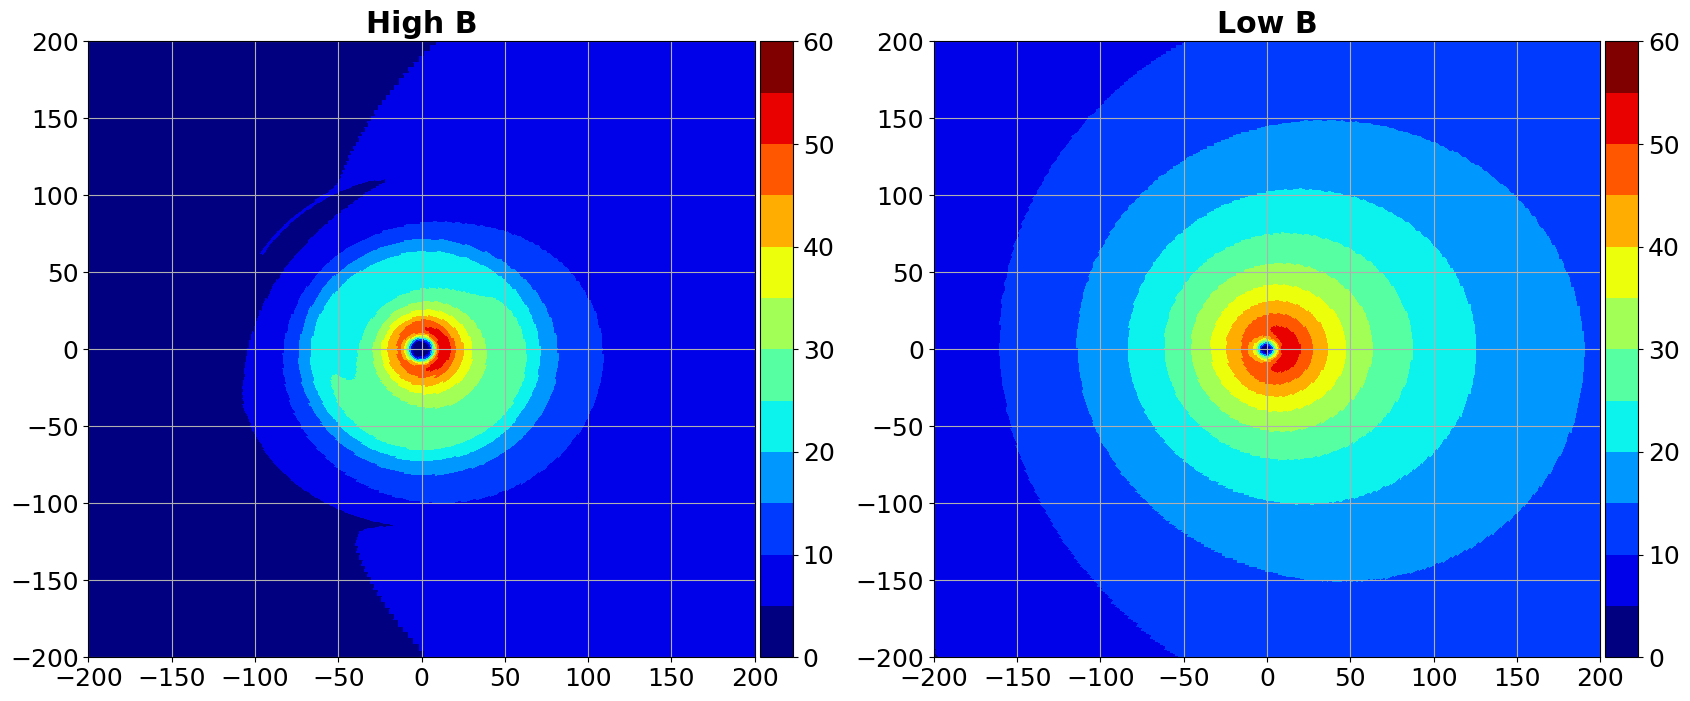

In [342]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

for ax, V_total, title in zip(axs, [np.sqrt(Vs_hgh ** 2 + Us_hgh ** 2), np.sqrt(Vs_low ** 2 + Us_low ** 2)], ['High', 'Low']):
    ax.set_title('{} B'.format(title), weight='bold')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    
    im = ax.pcolormesh(Xs_hol / 1000, Ys_hol / 1000, V_total, cmap=cm.get_cmap('jet', 12), vmin=0, vmax=60)
    fig.colorbar(im, cax=cax, orientation='vertical')
    ax.grid();ax.set_xlim(-200, 200);ax.set_ylim(-200, 200)
    # ax.grid();ax.set_xlim(-500, 500);ax.set_ylim(-500, 500)

0it [00:00, ?it/s]

/tmp/ipykernel_7896/1379363720.py:35: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im = ax.pcolormesh(Xs_hol / 1000, Ys_hol / 1000, V_total, cmap=cm.get_cmap('jet', 12), vmin=0, vmax=50)


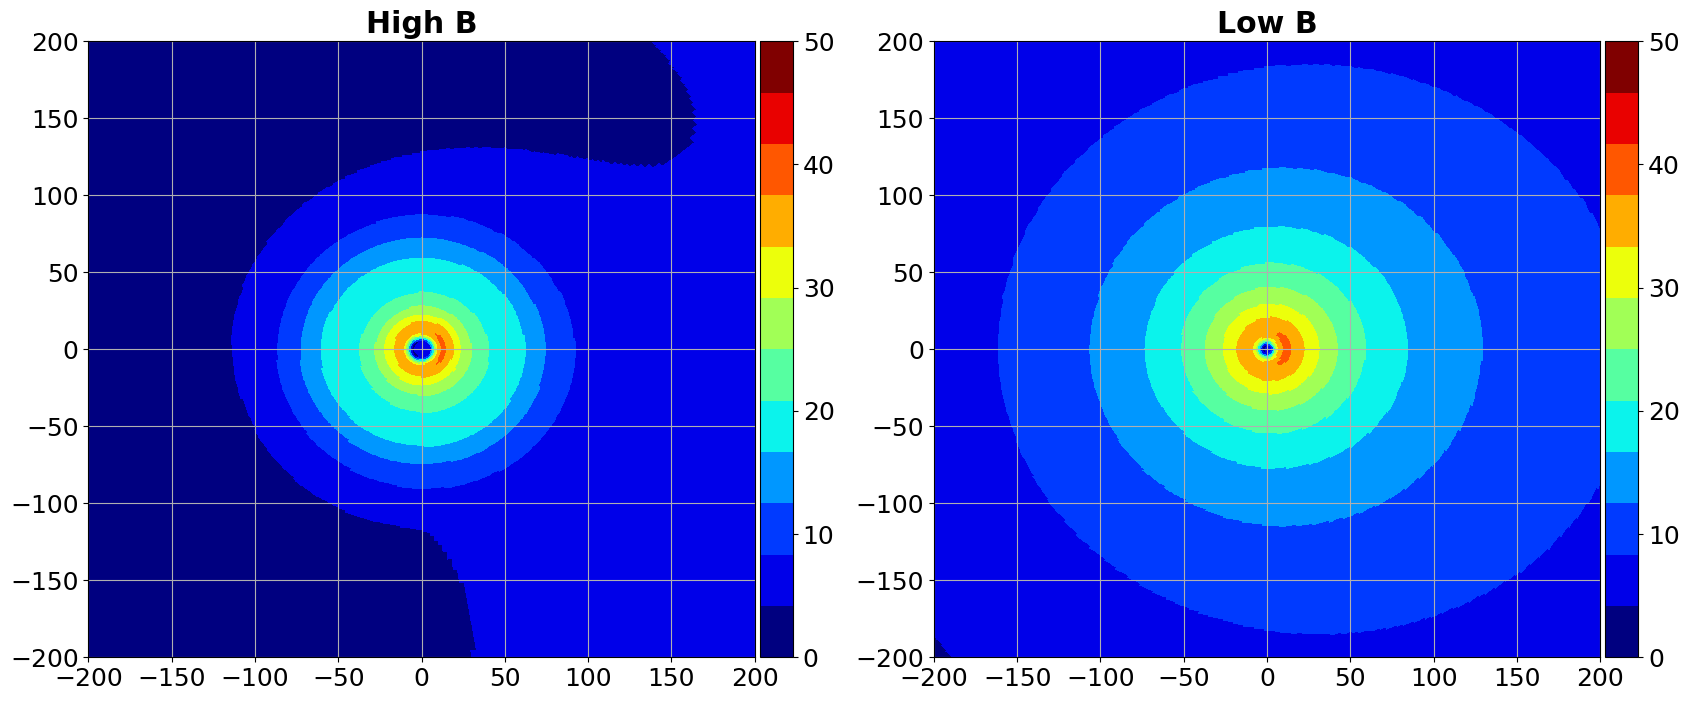

In [344]:
# Test with a HIGHER C

### Adding storm vector
K      = 50
C      = 1e-2
Ut     = 4.7
fcor   = coriolis(25)   

Us_low = np.ones_like(Rs)
Vs_low = np.ones_like(Rs)
Us_hgh = np.ones_like(Rs)
Vs_hgh = np.ones_like(Rs)

for i, th in tqdm(enumerate(ths)):
    Us_low[i, :] = u_BL(th, rs, V_low, Ut, K, C, fcor)
    Vs_low[i, :] = v_BL(th, rs, V_low, Ut, K, C, fcor)
    Us_hgh[i, :] = u_BL(th, rs, V_hgh, Ut, K, C, fcor)
    Vs_hgh[i, :] = v_BL(th, rs, V_hgh, Ut, K, C, fcor)
    
# Add storm speed vector
Us_low = Us_low + Ut * np.cos(THs)
Vs_low = Vs_low - Ut * np.sin(THs)
Us_hgh = Us_hgh + Ut * np.cos(THs)
Vs_hgh = Vs_hgh - Ut * np.sin(THs)

Xs_hol, Ys_hol = pol2cart(Rs, THs + np.pi/2) # Rotation at 90° to make the cyclone going northward

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

for ax, V_total, title in zip(axs, [np.sqrt(Vs_hgh ** 2 + Us_hgh ** 2), np.sqrt(Vs_low ** 2 + Us_low ** 2)], ['High', 'Low']):
    ax.set_title('{} B'.format(title), weight='bold')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    
    im = ax.pcolormesh(Xs_hol / 1000, Ys_hol / 1000, V_total, cmap=cm.get_cmap('jet', 12), vmin=0, vmax=50)
    fig.colorbar(im, cax=cax, orientation='vertical')
    ax.grid();ax.set_xlim(-200, 200);ax.set_ylim(-200, 200)
    # ax.grid();ax.set_xlim(-500, 500);ax.set_ylim(-500, 500)

0it [00:00, ?it/s]

/tmp/ipykernel_7896/3409234627.py:35: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im = ax.pcolormesh(Xs_hol / 1000, Ys_hol / 1000, V_total, cmap=cm.get_cmap('jet', 12), vmin=0, vmax=70)


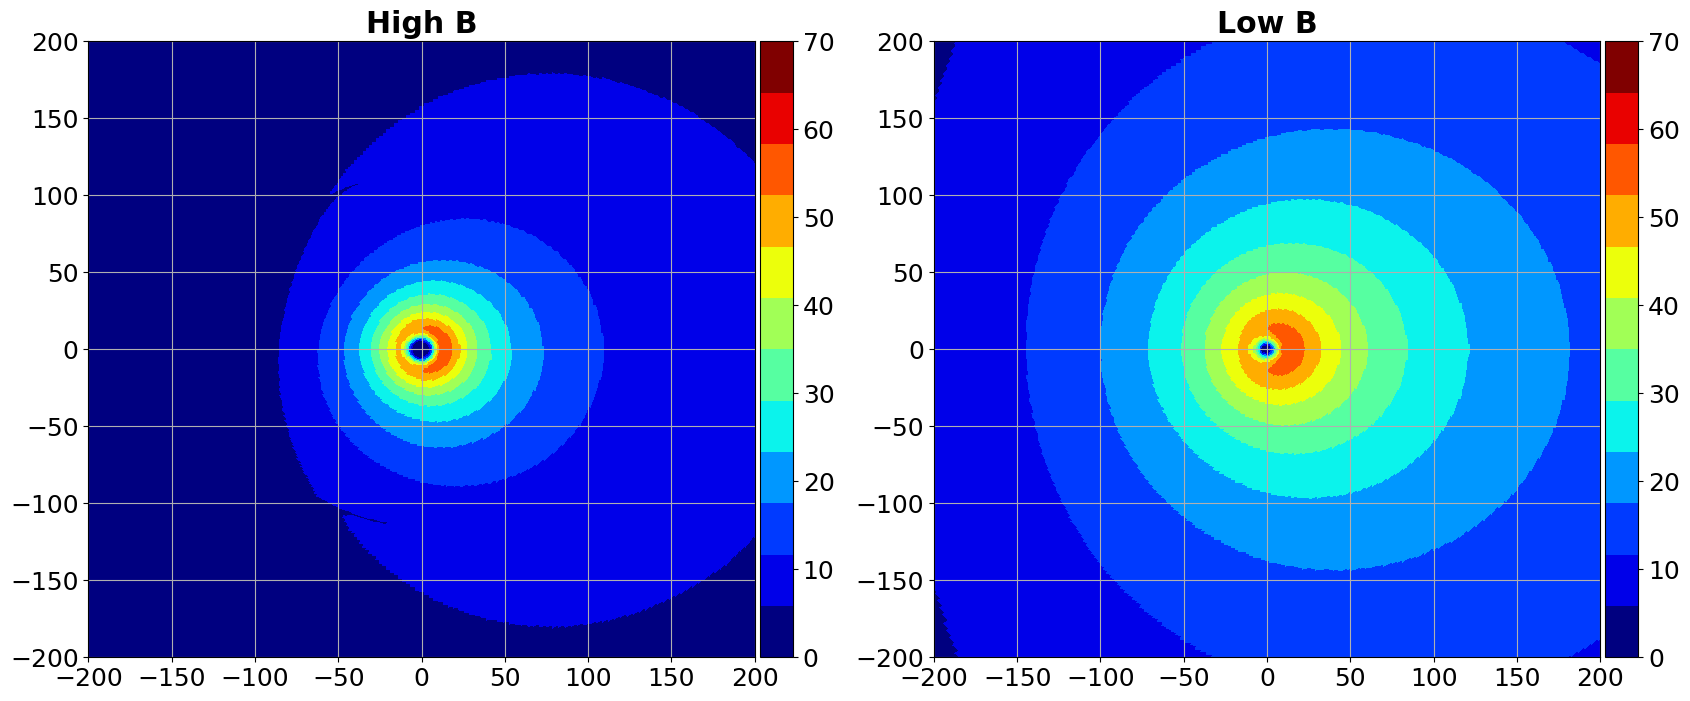

In [345]:
# Test with a LOWER C

### Adding storm vector
K      = 50
C      = 1e-4
Ut     = 4.7
fcor   = coriolis(25)   

Us_low = np.ones_like(Rs)
Vs_low = np.ones_like(Rs)
Us_hgh = np.ones_like(Rs)
Vs_hgh = np.ones_like(Rs)

for i, th in tqdm(enumerate(ths)):
    Us_low[i, :] = u_BL(th, rs, V_low, Ut, K, C, fcor)
    Vs_low[i, :] = v_BL(th, rs, V_low, Ut, K, C, fcor)
    Us_hgh[i, :] = u_BL(th, rs, V_hgh, Ut, K, C, fcor)
    Vs_hgh[i, :] = v_BL(th, rs, V_hgh, Ut, K, C, fcor)
    
# Add storm speed vector
Us_low = Us_low + Ut * np.cos(THs)
Vs_low = Vs_low - Ut * np.sin(THs)
Us_hgh = Us_hgh + Ut * np.cos(THs)
Vs_hgh = Vs_hgh - Ut * np.sin(THs)

Xs_hol, Ys_hol = pol2cart(Rs, THs + np.pi/2) # Rotation at 90° to make the cyclone going northward

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

for ax, V_total, title in zip(axs, [np.sqrt(Vs_hgh ** 2 + Us_hgh ** 2), np.sqrt(Vs_low ** 2 + Us_low ** 2)], ['High', 'Low']):
    ax.set_title('{} B'.format(title), weight='bold')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    
    im = ax.pcolormesh(Xs_hol / 1000, Ys_hol / 1000, V_total, cmap=cm.get_cmap('jet', 12), vmin=0, vmax=70)
    fig.colorbar(im, cax=cax, orientation='vertical')
    ax.grid();ax.set_xlim(-200, 200);ax.set_ylim(-200, 200)
    # ax.grid();ax.set_xlim(-500, 500);ax.set_ylim(-500, 500)

### Test with SAR: same B, same everything

In [473]:
d = dsg.where((dsg.Vmax_1D > 25) & (dsg.Vmax_1D <= 35), drop=True)
d = d.where((d.cyclone_speed > 5.5) & (d.cyclone_speed <= 6.5), drop=True)
# d = d.where((d.B_hol > 1.5) & (d.B_hol <= 1.9), drop=True)
d = d.where((d.lat_center > 15) & (d.lat_center <= 20), drop=True)
print(d.B_hol.data)
print(d.Vmax_1D.data)
print(d.cyclone_speed.data)
print(d.lat_center.data)
print(d.Rmax_1D.data)

[1.93012954 1.96055212 2.60554208]
[33.57874075 33.52853291 27.20856468]
[6.09413309 5.8489197  5.52737243]
[15.39381464 18.9307943  15.84089496]
[19. 31. 23.]


In [474]:
d_hgh = d.isel(time=0) # High Holland B
print(d_hgh.sat_file.item())
print('B     = {:.2f}'.format(d_hgh.B_hol))
print('Speed = {:.2f}'.format(d_hgh.cyclone_speed))
print('Vmax  = {:.1f}'.format(d_hgh.Vmax_1D))
print('Rmax  = {:.1f}'.format(d_hgh.Rmax_1D))
print('Lat   = {:.1f}'.format(d_hgh.lat_center))

rs2--owi-cm-20201002t022254-20201002t022409-00003-3268A_sw.nc
B     = 1.93
Speed = 6.09
Vmax  = 33.6
Rmax  = 19.0
Lat   = 15.4


In [475]:
d_low = d.isel(time=1) # Low Holland B
print(d_low.sat_file.item())
print('B     = {:.2f}'.format(d_low.B_hol))
print('Speed = {:.2f}'.format(d_low.cyclone_speed))
print('Vmax  = {:.1f}'.format(d_low.Vmax_1D))
print('Rmax  = {:.1f}'.format(d_low.Rmax_1D))
print('Lat   = {:.1f}'.format(d_low.lat_center))

rs2--owi-cm-20161105t201351-20161105t201507-00003-E08E1_sw.nc
B     = 1.96
Speed = 5.85
Vmax  = 33.5
Rmax  = 31.0
Lat   = 18.9


/tmp/ipykernel_7896/135357248.py:8: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im = ax.pcolormesh(X_SAR / 1000, Y_SAR / 1000, ds.wind_speed.transpose(), cmap=cm.get_cmap('jet', 12), vmin=5, vmax=45)


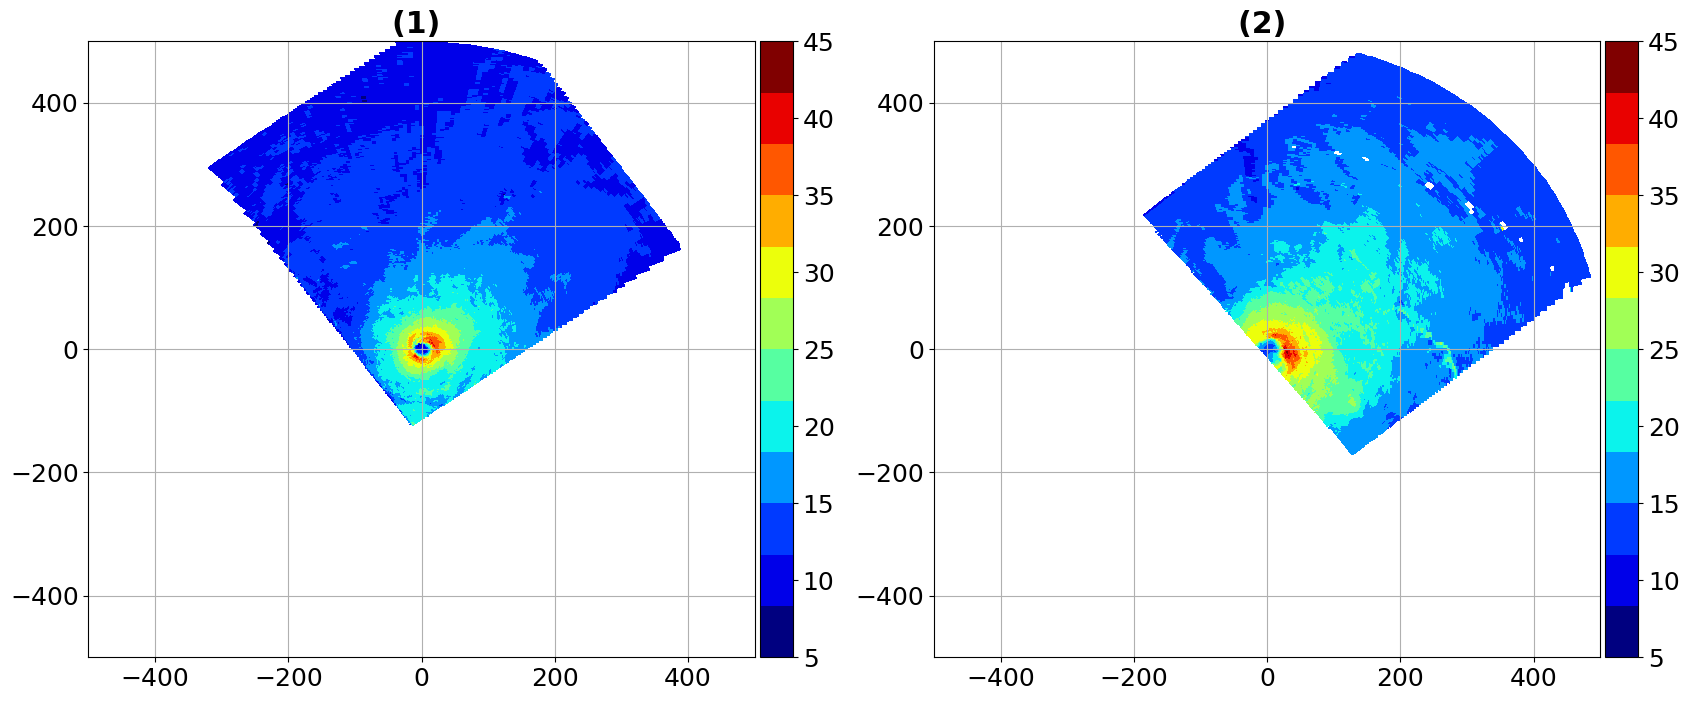

In [493]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

for ax, ds, title in zip(axs, [d_hgh, d_low], ['(1)', '(2)']):
    ax.set_title('{} '.format(title), weight='bold')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    
    im = ax.pcolormesh(X_SAR / 1000, Y_SAR / 1000, ds.wind_speed.transpose(), cmap=cm.get_cmap('jet', 12), vmin=5, vmax=45)
    fig.colorbar(im, cax=cax, orientation='vertical')
    # ax.grid();ax.set_xlim(-200, 200);ax.set_ylim(-200, 200)
    ax.grid();ax.set_xlim(-500, 500);ax.set_ylim(-500, 500)

0it [00:00, ?it/s]

/tmp/ipykernel_7896/1537958471.py:30: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im = ax.pcolormesh(Xs_hol / 1000, Ys_hol / 1000, np.sqrt(Us_hol ** 2 + Vs_hol ** 2), cmap=cm.get_cmap('jet', 30), vmin=5, vmax=40)


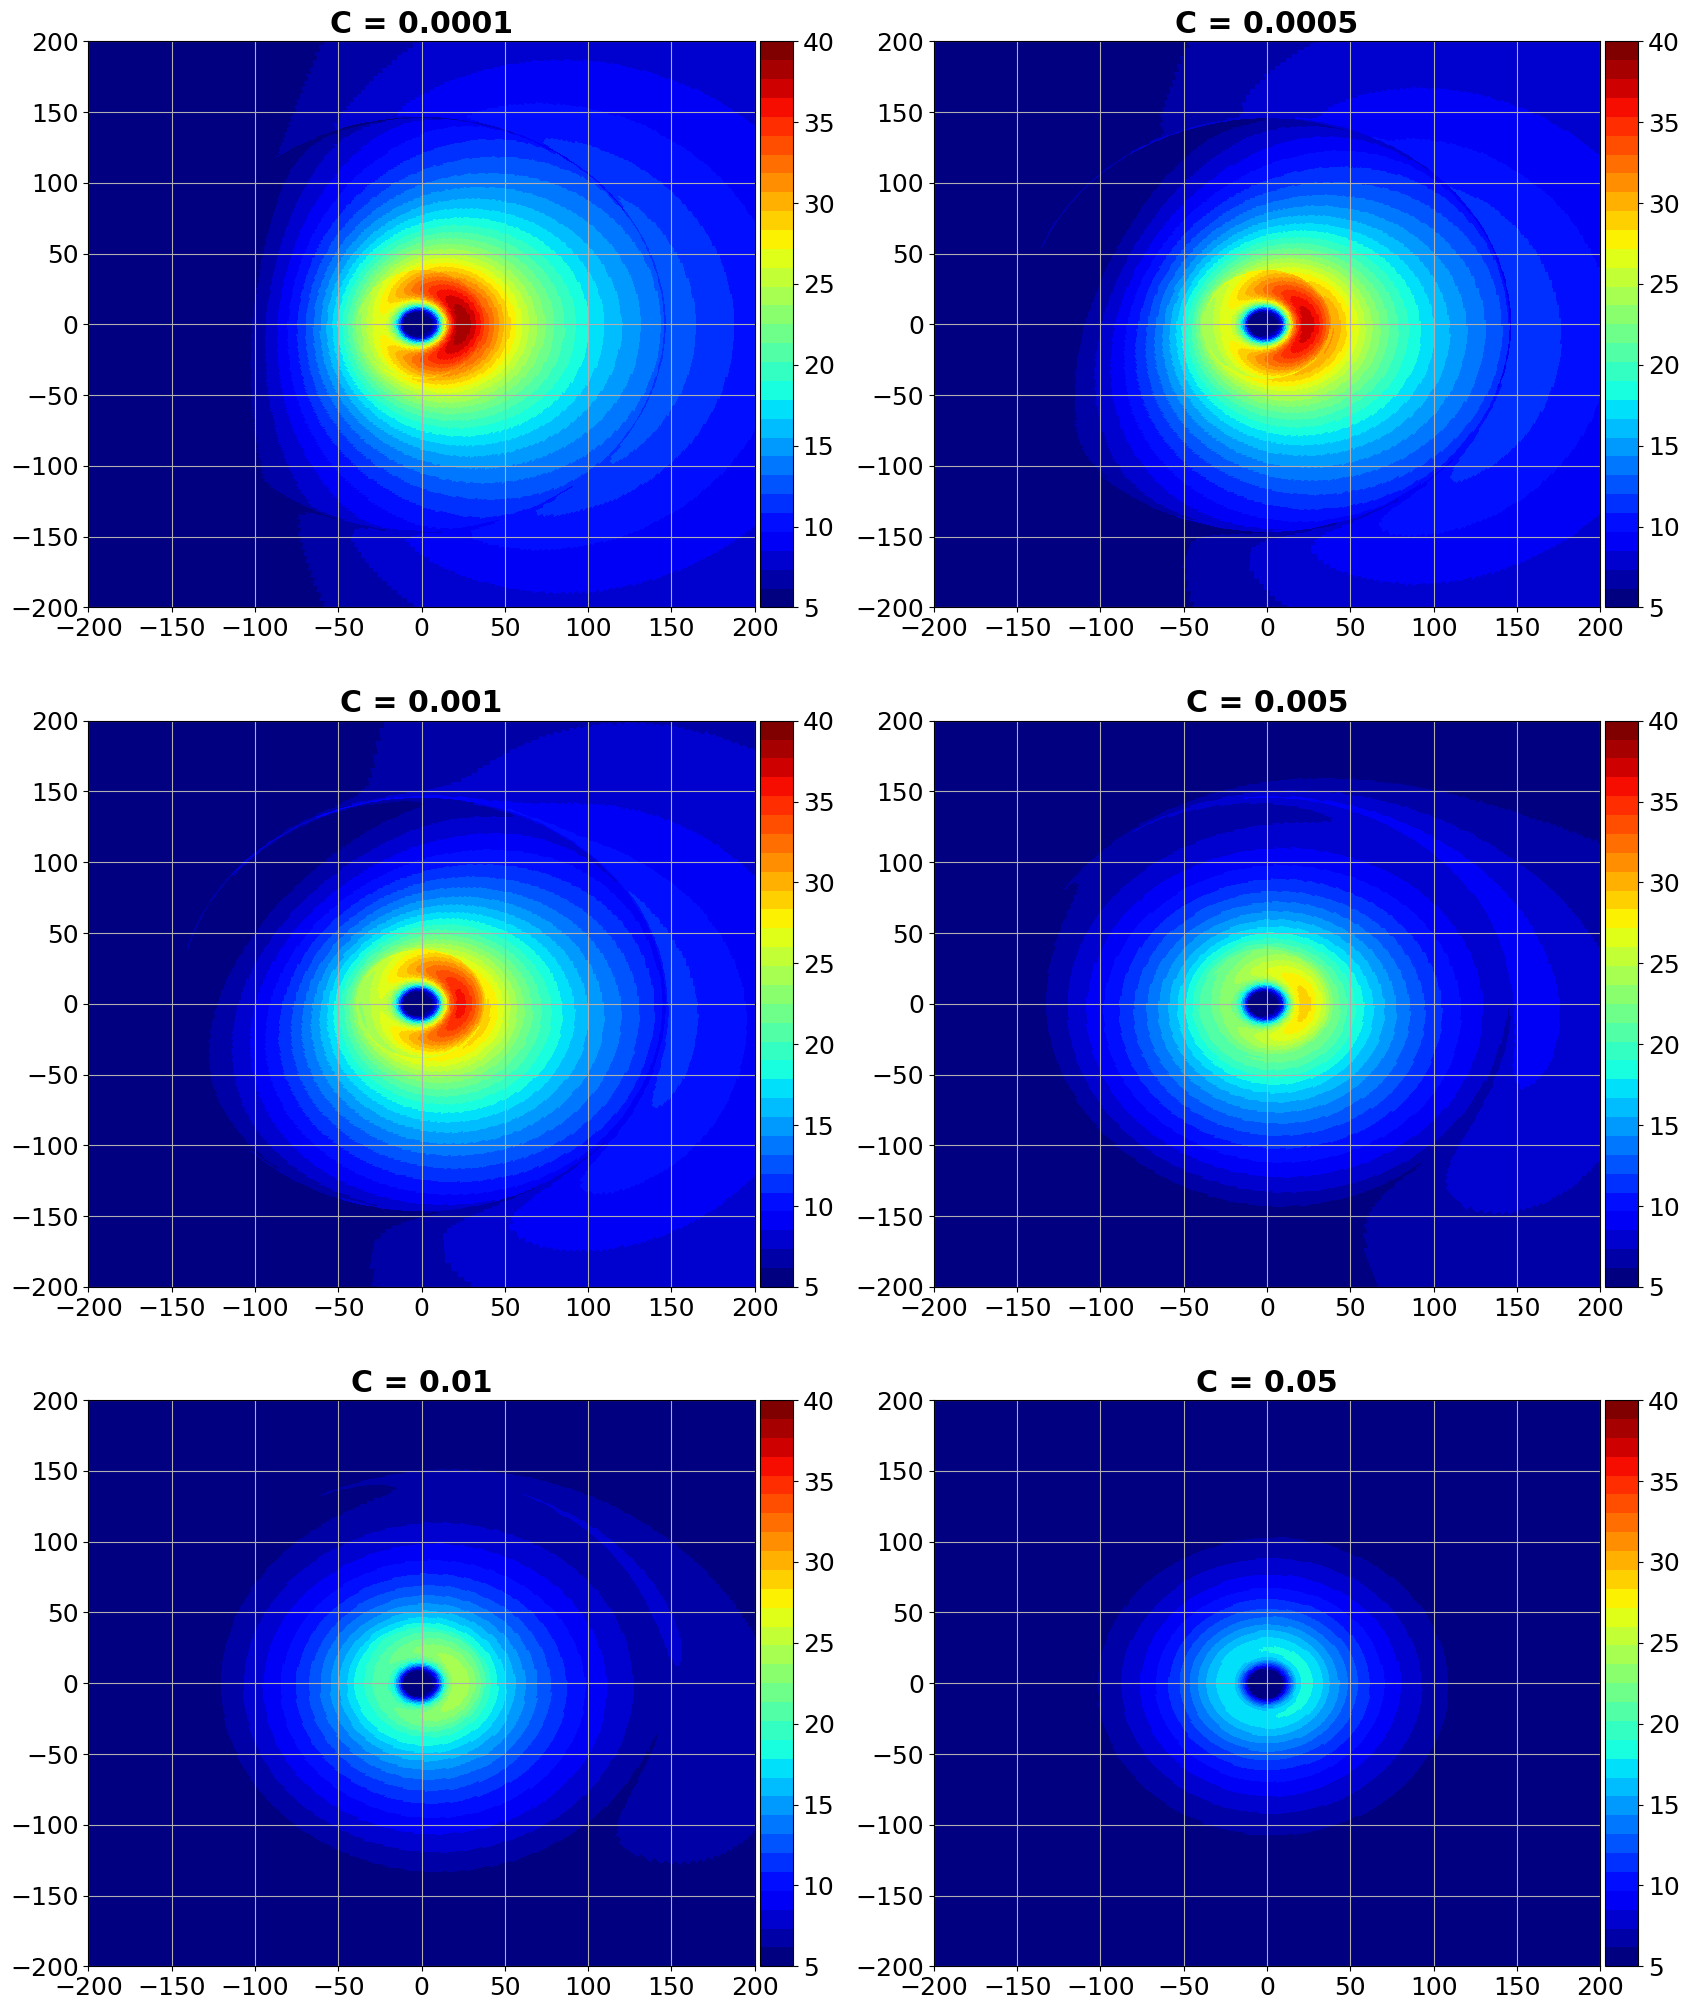

In [494]:
# Test with a LOWER C

V_hol = h80(rs, vm=33.5, rm=25000, B=1.9, lat=17)

### Adding storm vector
K      = 50
C      = 1e-3
Ut     = 6
fcor   = coriolis(17)   


fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(20, 25))

for ax, C in tqdm(zip(fig.axes, [1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2])):
    Us_hol = np.ones_like(Rs)
    Vs_hol = np.ones_like(Rs)

    for i, th in enumerate(ths):
        Us_hol[i, :] = u_BL(th, rs, V_hol, Ut, K, C, fcor)
        Vs_hol[i, :] = v_BL(th, rs, V_hol, Ut, K, C, fcor)

    # Add storm speed vector
    Us_hol = Us_hol + Ut * np.cos(THs)
    Vs_hol = Vs_hol - Ut * np.sin(THs)
    
    ax.set_title('C = {}'.format(C), weight='bold')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    
    im = ax.pcolormesh(Xs_hol / 1000, Ys_hol / 1000, np.sqrt(Us_hol ** 2 + Vs_hol ** 2), cmap=cm.get_cmap('jet', 30), vmin=5, vmax=40)
    fig.colorbar(im, cax=cax, orientation='vertical')
    ax.grid();ax.set_xlim(-200, 200);ax.set_ylim(-200, 200)
    # ax.grid();ax.set_xlim(-500, 500);ax.set_ylim(-500, 500)

#### Comparison of I > V/r and I < V/r solutions

In [504]:
###############
### I > V/r ###
###############

def u1_sup(theta, r, V, Ut, K, C, fcor):
    return np.squeeze(sqrt_alpha_beta(r, V, fcor) * np.real(A1(r, V, Ut, K, C, fcor)       * np.exp(1j * theta)))

def v1_sup(theta, r, V, Ut, K, C, fcor):
    return np.squeeze(np.imag(A1(r, V, Ut, K, C, fcor)       * np.exp(1j * theta)))

def u_1_sup(theta, r, V, Ut, K, C, fcor):
    return np.squeeze(sqrt_alpha_beta(r, V, fcor) * np.real(A_1(r, V, Ut, K, C, fcor)       * np.exp(-1j * theta)))

def v_1_sup(theta, r, V, Ut, K, C, fcor):
    return np.squeeze(np.imag(A_1(r, V, Ut, K, C, fcor)       * np.exp(-1j * theta)))

def u_BL_sup(theta, r, V, Ut, K, C, fcor):
    return u_1_sup(theta, r, V, Ut, K, C, fcor) + u0(r, V, K, C, fcor) + u1_sup(theta, r, V, Ut, K, C, fcor)

def v_BL_sup(theta, r, V, Ut, K, C, fcor):
    return V + v_1_sup(theta, r, V, Ut, K, C, fcor) + v0(r, V, K, C, fcor) + v1_sup(theta, r, V, Ut, K, C, fcor)

###############
### I < V/r ###
###############

def u1_inf(theta, r, V, Ut, K, C, fcor):
    return np.squeeze(sqrt_alpha_beta(r, V, fcor) * np.real(A1_prime(r, V, Ut, K, C, fcor) * np.exp(1j * theta)))

def v1_inf(theta, r, V, Ut, K, C, fcor):
    return np.squeeze(np.imag(A1_prime(r, V, Ut, K, C, fcor) * np.exp(1j * theta)))

def u_1_inf(theta, r, V, Ut, K, C, fcor):
    return np.squeeze(sqrt_alpha_beta(r, V, fcor) * np.real(A_1_prime(r, V, Ut, K, C, fcor) * np.exp(-1j * theta)))

def v_1_inf(theta, r, V, Ut, K, C, fcor):
    return np.squeeze(np.imag(A_1_prime(r, V, Ut, K, C, fcor) * np.exp(-1j * theta)))

# TOTAL WIND COMPONENTS IN THE BL
def u_BL_inf(theta, r, V, Ut, K, C, fcor):
    return u_1_inf(theta, r, V, Ut, K, C, fcor) + u0(r, V, K, C, fcor) + u1_inf(theta, r, V, Ut, K, C, fcor)

def v_BL_inf(theta, r, V, Ut, K, C, fcor):
    return V + v_1_inf(theta, r, V, Ut, K, C, fcor) + v0(r, V, K, C, fcor) + v1_inf(theta, r, V, Ut, K, C, fcor)

In [528]:
rs = np.linspace(10, 8e5, 800)
vmx = 50
rmx = 50000
B   = 2
lat = 20

V   = h80(rs, vmx, rmx, B, lat)
fcor= coriolis(lat)

# plt.plot(rs, v);plt.grid()

In [535]:
K   = 50 # m2/s
Ut  = 5     # Translation speed
C   = 1e-2

Us_sup = np.ones_like(Rs)
Vs_sup = np.ones_like(Rs)
Us_inf = np.ones_like(Rs)
Vs_inf = np.ones_like(Rs)

for i, th in tqdm(enumerate(ths)):
    # print(i, th)
    Us_sup[i, :] = u_BL_sup(th, rs, V, Ut, K, C, fcor)
    Vs_sup[i, :] = v_BL_sup(th, rs, V, Ut, K, C, fcor)
    Us_inf[i, :] = u_BL_inf(th, rs, V, Ut, K, C, fcor)
    Vs_inf[i, :] = v_BL_inf(th, rs, V, Ut, K, C, fcor)
    
V_sup_total = np.sqrt(Us_sup ** 2 + Vs_sup ** 2)
V_inf_total = np.sqrt(Us_inf ** 2 + Vs_inf ** 2)

0it [00:00, ?it/s]

/tmp/ipykernel_7896/2115036850.py:9: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im = ax.pcolormesh(Xs / 1000, Ys / 1000, V_tot, cmap=cmap, norm=normalizer)


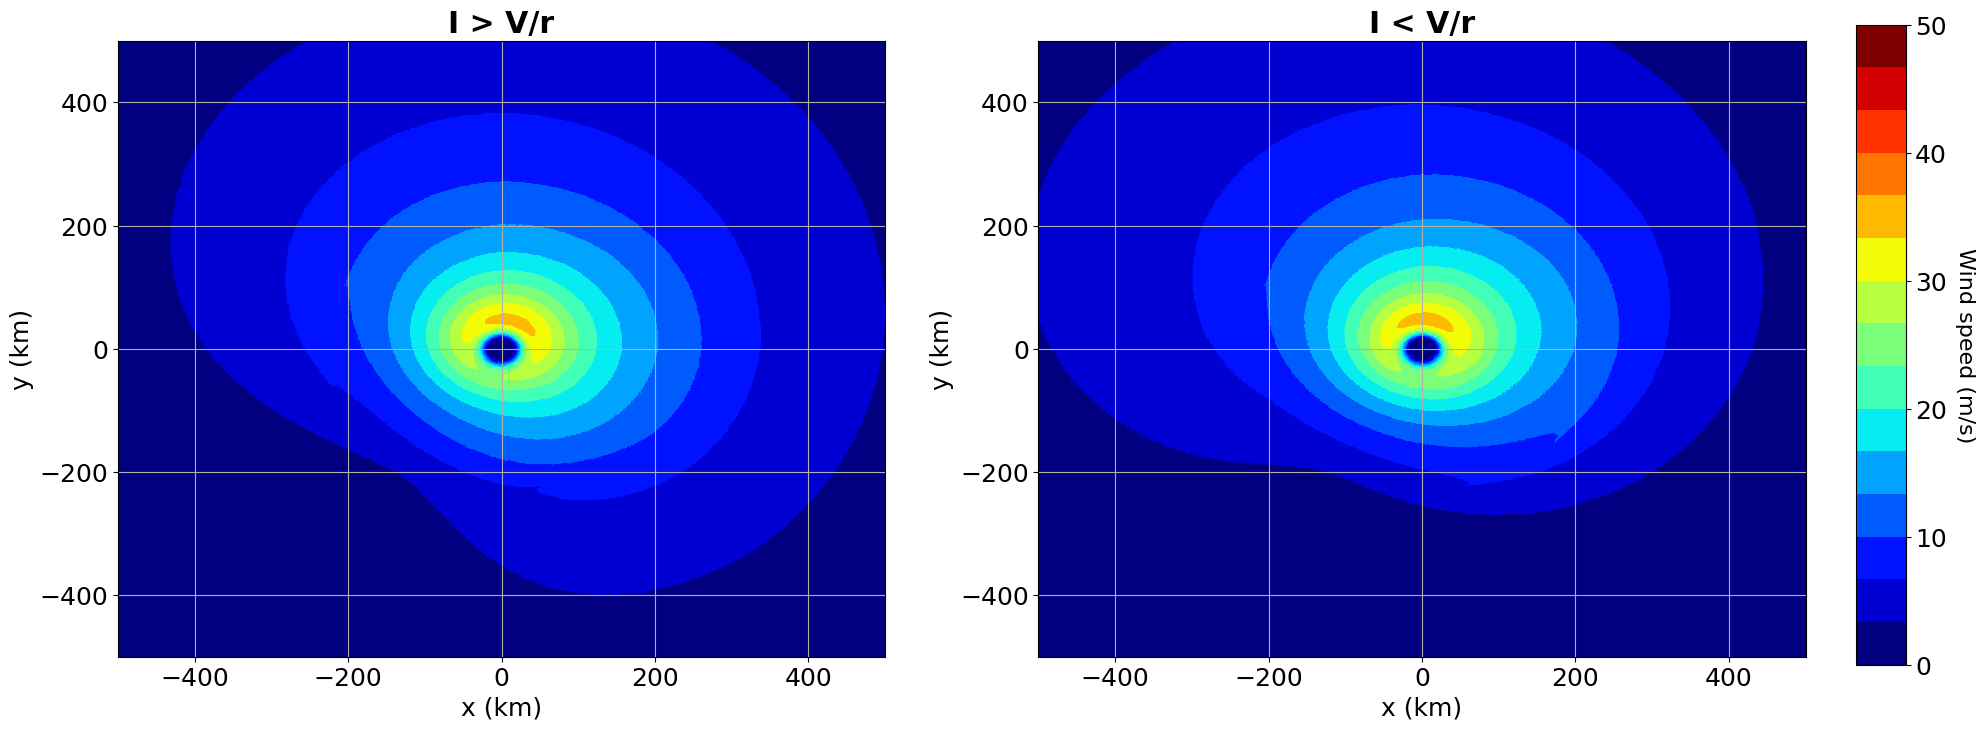

In [536]:
cmap       = cm.get_cmap('jet', 15)
normalizer = Normalize(0, 50)
im         = cm.ScalarMappable(norm=normalizer)
fig, axs   = plt.subplots(nrows=1, ncols=2, figsize=(25, 8))

for ax, V_tot, title in zip(axs, [V_sup_total, V_inf_total], ['I > V/r', 'I < V/r']):
        
    ax.set_title('{}'.format(title), weight='bold')
    im = ax.pcolormesh(Xs / 1000, Ys / 1000, V_tot, cmap=cmap, norm=normalizer)
    ax.grid();ax.set_xlim(-500, 500);ax.set_ylim(-500, 500);ax.set_xlabel('x (km)');ax.set_ylabel('y (km)')
    
# Colorbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.1, 0.02, 0.8])
cbar    = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('Wind speed (m/s)', rotation=270, fontsize=16)
cbar.ax.get_yaxis().labelpad=20